# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)

## Class 06 — Regression Pt. 2: Expectation & Likelihood


This notebook is the in-class companion to the **Class 06 (and kinda 07)** slides.

**Where we are in the course:**

- Class 04: distributions, odds, surprise
- Class 05: regression as a translation device (Moneyball)
- **Class 06 (today):** expectation + likelihood (how we build probabilistic regressions like xG)

> Big theme: in sports, we rarely care only about a point estimate.

> We care about *expected outcomes*, *uncertainty*, and *decision-making under uncertainty*.

As always, course materials live here: https://github.com/jkbren/cnet5442_sp26

_______
## Plan for today (ehhh ***maybe***)

1. **~5 minutes**: finish / debrief the Class 05 Moneyball notebook.
2. **~45 minutes**: IN-CLASS GROUP ASSIGNMENT!
    - Pick a group: Soccer or basketball.
3. **~50 minutes**: expectation + likelihood + xG + heatmaps.


One goal of today is to make it feel obvious why we move from:

- *Moneyball regression:* $\text{wins} \approx \beta_0 + \beta_1\,\text{OBP} + \beta_2\,\text{SLG} + \cdots$

to:

- *Expected goals:* $xG(\text{shot}) = P(\text{goal} \mid \text{shot context})$,
- and then to *likelihood* to fit those probability models.

_______

In [2]:
# --- Imports and setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools as it

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve

import statsmodels.api as sm

from scipy.stats import gaussian_kde


In [4]:
np.random.seed(5442)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 60)

In [5]:
def sigmoid(z):
    """Logistic sigmoid function.

    This is the workhorse link function for logistic regression. It maps
    any real-valued input to a probability in (0, 1):

    $$\sigma(z) = \frac{1}{1 + e^{-z}}.$$
    """
    return 1 / (1 + np.exp(-z))

print('Ready.')

Ready.


_______
## Part 0 — The bridge: Moneyball regression → expectation

In Class 05, we used regression as a **translation device**:

$$
Y = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p + \varepsilon.
$$

That form is incredibly useful, but today we want the *concept* underneath it.



### The underlying object

In many problems, what we actually want is the **conditional average outcome**:

$$
\mathbb{E}[Y \mid X].
$$

Examples:

- $Y$ = team win percentage; $X$ = (OBP, SLG, opponent OBP, opponent SLG).
- $Y$ = shot outcome (goal=1, no goal=0); $X$ = (shot distance, angle, body part, assist type, …).
- $Y$ = points scored on a possession; $X$ = (lineup, location, defense spacing, time, …).


### Key translation

- When $Y$ is **numeric**, $\mathbb{E}[Y\mid X]$ is an expected value.
- When $Y\in\{0,1\}$ is **binary**, $\mathbb{E}[Y\mid X]$ is a probability.

Because if $Y\in\{0,1\}$ and $P(Y=1\mid X)=p(X)$, then:

$$
\mathbb{E}[Y\mid X] = 1\cdot p(X) + 0\cdot(1-p(X)) = p(X).
$$

This one line is basically the conceptual bridge from Moneyball-style regression to xG.


![](images/chatsillygpt.png)

(I'm so sorry for the silly image...)

____________________
## Pick a side

![](images/chatgpt_soccer_basketball_videogame.png)

__________
### Team 1: Basketball
Real NBA shot-level data (`NBA_2024_Shots.csv`): one row per shot, with a made/miss outcome plus spatial and contextual descriptors. This kind of dataset sits in a sweet spot for sports analytics: it’s large enough to support real modeling work, and simple enough that we can reason clearly about what an expected value model is doing. In the NBA shot dataset we’ll use, you can expect fields like team and player identifiers, shot outcome (made/missed), shot type (2PT/3PT), coarse zone labels, remaining time, and $(x,y)$ shot coordinates on the court (plus derived shot distance).

[1]: https://github.com/DomSamangy/NBA_Shots_04_25 "GitHub - DomSamangy/NBA_Shots_04_25: NBA regular season shot location data from the 2003-04 season to 2024-25 w/ data viz example code."

A nice way to translate xG into basketball language is: **shot make probability** (and subsequently **expected points**). If $Y \in {0,1}$ is "made shot," then $E[Y \mid X] = P(Y=1 \mid X)$ is already an expectation object; multiply by point value to get expected points. The core modeling question becomes: *what information goes into $X$?* Location alone gets you surprisingly far; adding context (clock, quarter, shot type, etc.) is where models start to feel more realistic.

**In-class group task:** poke around, visualize the shot cloud and a simple heatmap, then propose three xG-style designs:

* **Simple:** empirical binning (e.g., by zone, or by distance bands) $\Rightarrow$ rate = makes / attempts.
* **Moderate:** ?? <!-- a logistic regression for $P(\text{make}\mid \text{distance, angle, shot type, time})$ with calibration checks. -->
* **Challenging:** ?? <!-- a richer model (nonlinear terms/splines, hierarchical player effects, defender/spacing features if available, or a modern classifier) and a careful evaluation plan. -->


<!-- # w = 2.55; h = 2.5
# nrows = 3
# ncols = 7
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=300)
# plt.subplots_adjust(wspace=0.15,hspace=0.25)

# for ix,year in enumerate(list(range(2005,2026))):
#     bball = pd.read_csv('data/bball/NBA_%i_Shots.csv'%year)

#     a = ax[tups[ix]]
#     a.scatter(bball['LOC_X'].values,
#               bball['LOC_Y'].values,marker='.',lw=0,alpha=0.025,s=5)

#     a.set_title(year)

#     a.hlines(50,-25,30,color='k',lw=0.5,ls='--')
#     a.hlines(0,-25,30,color='k',lw=0.5,ls='--')
#     a.vlines(-25,0,100,color='k',lw=0.5,ls='--')
#     a.vlines(25,0,100,color='k',lw=0.5,ls='--')
#     a.set_ylim(-2,52)
#     a.set_xlim(-26,26)
#     a.set_xticks([])
#     a.set_yticks([])


# plt.show() -->

In [6]:
year = 2024
bball = pd.read_csv('data/bball/NBA_%i_Shots.csv'%year)
bball.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,MIA,WAS,Missed Shot,False,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.35,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,MIA,WAS,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,1.5,30.45,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,MIA,WAS,Made Shot,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.45,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,MIA,WAS,Made Shot,True,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.75,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,MIA,WAS,Made Shot,True,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,6.15,1,1,8,8


<!-- import matplotlib.patheffects as path_effects
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors


w = 2.0; h = 2.0
nrows = 3
ncols = 7
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w, nrows*h), dpi=300)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# --- KDE-like settings (tweak as needed) ---
xlim = (-26, 26)
ylim = (-1, 51)
bins = 180          # higher = finer density grid (slower, but still pretty fast)
sigma = 1.2         # smoothing in "bin units" (bigger = smoother)
eps = 1e-12         # to keep LogNorm happy


for ix, year in enumerate(list(range(2005, 2026))):
    bball = pd.read_csv('data/bball/NBA_%i_Shots.csv' % year)

    # drop NaNs just in case
    x = bball['LOC_X'].to_numpy()
    y = bball['LOC_Y'].to_numpy()
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]

    a = ax[tups[ix]]

    # 2D histogram on the visible court window
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[xlim, ylim])
    H = gaussian_filter(H, sigma=sigma)

    # map each point -> smoothed density value via bin lookup
    xi = np.clip(np.searchsorted(xedges, x, side="right") - 1, 0, H.shape[0] - 1)
    yi = np.clip(np.searchsorted(yedges, y, side="right") - 1, 0, H.shape[1] - 1)
    z = H[xi, yi] + eps

    # plot low-density first, high-density last (looks better)
    order = np.argsort(z)
    z_ord = z[order]

    # robust per-panel normalization (avoid a few hot bins blowing out the scale)
    vmin = np.percentile(z_ord, 5)
    vmax = np.percentile(z_ord, 99.7)
    norm = mcolors.LogNorm(vmin=max(vmin, eps), vmax=max(vmax, vmin * 1.01))

    a.scatter(
        x[order], y[order],
        c=z_ord,
        cmap="magma",
        norm=norm,
        marker=".",
        lw=0,
        s=4,
        alpha=0.15,
        rasterized=True
    )

    a.set_title(year, x=0.975, y=0.91, ha='right', va='top',
                fontweight='bold', color='.8', fontsize='x-large',
                path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                              path_effects.Normal()])

    a.set_ylim(*ylim)
    a.set_xlim(*xlim)
    a.set_xticks([])
    a.set_yticks([])


# plt.savefig('images/pngs/heatmap_basketball.png',dpi=600,bbox_inches='tight')
# plt.savefig('images/pdfs/heatmap_basketball.pdf',dpi=600,bbox_inches='tight')
plt.show() -->

---

### Team 2: Soccer

For soccer we'll use a shot-level file (`data/EPL_2024_shots.csv`) that reflects a common event-data view: one row per shot, with location and some context, and a binary goal outcome. A big reason soccer is the canonical xG setting is that goals are rare and shots vary wildly in quality—so modeling $P(\text{goal} \mid X)$ gives you a principled way to compare teams/players beyond raw goals.

Understat publishes shot maps and assigns an xG value to each shot, based on a model. Understat-derived shot tables commonly include fields like shot coordinates $(X,Y)$, shot outcome, minute, situation (open play, set piece, etc.), shot type, and the shot's xG value.

**In-class group task:** do quick exploratory visuals (shot scatter + goal-rate heatmap), then propose three xG designs:

* **Simple:** binning by distance/angle or coarse zones $\Rightarrow$ empirical goal rate per bin.
* **Moderate:** ?? <!-- logistic regression for $P(\text{goal}\mid \text{distance, angle, situation, body part})$ with regularization + calibration. -->
* **Challenging:** ?? <!-- a richer model (splines/interactions, hierarchical effects for players/teams, adding game-state covariates, or comparing multiple model classes) with a clean train/test split and evaluation via log loss + reliability curves. -->

In [6]:
year = 2024
socc = pd.read_csv('data/soccer/EPL_%i_shots.csv'%year)
socc.head()

,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
0,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584627,7,MissedShots,Adama Traoré,900,Rodrigo Muniz,OpenPlay,RightFoot,Pass,0.867,0.278,0.036473
1,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584628,12,SavedShot,Kenny Tete,5973,Andreas Pereira,OpenPlay,RightFoot,Pass,0.727,0.501,0.021440
2,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584629,13,BlockedShot,Rodrigo Muniz,10717,Andreas Pereira,FromCorner,Head,Cross,0.889,0.456,0.037385
3,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,h,Manchester United,584630,19,MissedShots,Bruno Fernandes,1228,Lisandro Martínez,OpenPlay,LeftFoot,Chipped,0.971,0.673,0.050078
4,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,h,Manchester United,584631,26,MissedShots,Casemiro,2248,Mason Mount,OpenPlay,RightFoot,Pass,0.747,0.479,0.020807


## In-class activity: Build "xG" (ish) from real data (group work + 5-minute share-out)

Split into two groups and pick **one dataset** to work with: `EPL_2024_shots.csv` (soccer) or `NBA_2024_Shots.csv` (basketball). Your job is to do a fast-but-serious exploratory pass and then propose a plan for computing an xG-style model at three levels of complexity.


### Part A. Quick data reconnaissance (10–12 minutes)

1. Load the CSV and print:
   - shape, column names, and a 5-row preview  
   - missingness summary (how many NaNs per column)

2. Identify:
   - the **outcome variable** ($Y$): goal vs no-goal, make vs miss  
   - the **core covariates** ($X$): shot location, distance, angle, time/clock variables, situation/shot type, etc.

3. Make at least **two plots**:
   - a **shot scatter plot** in the correct coordinate space (pitch/court)  
   - a **heatmap** (either shot density or goal/make rate) using simple binning


### Part B. Propose three xG designs (10–12 minutes)

For each of the three options below, write down:

- what features you'd use ($X$),
- what model/estimator you’d use,
- what the output means (per-shot probability, expected points, etc.),
- and one way you’d evaluate or sanity-check it.

1. **Simple** (purely empirical):
   - Example: bin by distance and/or angle (or zones) and estimate
     $$\hat p(\text{score} \mid \text{bin}) = \frac{\#\text{goals in bin}}{\#\text{shots in bin}}.$$

2. **Moderate** (standard statistical model):
   - Example: logistic regression for
     $$P(Y=1\mid X)=\sigma(X\beta), \qquad \sigma(z)=\frac{1}{1+e^{-z}}.$$
   - Think about regularization, train/test split, and calibration.

3. **Challenging** (richer model + stronger evaluation):
   - Example directions: splines/interactions, hierarchical player/team effects, nonparametric models, comparing model classes, careful cross-validation, and multiple evaluation metrics (log loss + calibration plots).


### Part C. Make a mini-deck (Google Slides) and present (5 minutes per group)

Create **3–5 slides**: Go to [slides.new](slides.new) --- we're gonna be doing some presentations of our results!

1. **Dataset + outcome**: what’s in the file, what $Y$ is, what you think $X$ should be.
2. **Two visuals**: scatter + heatmap (with labels and a one-sentence takeaway each).
3. **Your xG plan**: simple / moderate / challenging (one slide total, or one slide each if you prefer).
4. **One risk + one mitigation**: what could go wrong (data quality, sample size, leakage, coordinate conventions, bias) and how you’d address it.



In [7]:
bball

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,MIA,WAS,Missed Shot,False,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.35,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,MIA,WAS,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,1.5,30.45,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,MIA,WAS,Made Shot,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.45,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,MIA,WAS,Made Shot,True,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.75,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,MIA,WAS,Made Shot,True,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,6.15,1,1,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218696,2024,2023-24,1610612737,Atlanta Hawks,203992,Bogdan Bogdanovic,G,SG,12-08-2023,22301218,PHI,ATL,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,11.9,29.75,27,4,0,48
218697,2024,2023-24,1610612737,Atlanta Hawks,203991,Clint Capela,C,C,12-08-2023,22301218,PHI,ATL,Missed Shot,False,Tip Layup Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,8-16 ft.,1.6,14.15,9,4,0,45
218698,2024,2023-24,1610612737,Atlanta Hawks,203991,Clint Capela,C,C,12-08-2023,22301218,PHI,ATL,Made Shot,True,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,Less Than 8 ft.,0.6,9.65,4,4,0,44
218699,2024,2023-24,1610612737,Atlanta Hawks,1627749,Dejounte Murray,G,SG,12-08-2023,22301218,PHI,ATL,Made Shot,True,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,-1.7,34.45,29,4,0,37


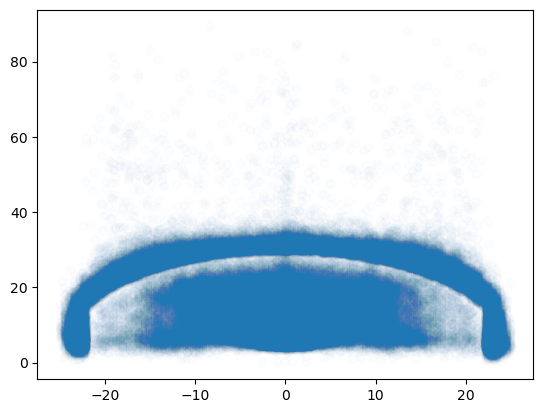

In [15]:
plt.scatter(bball['LOC_X'], bball['LOC_Y'], alpha=0.01)

In [56]:
#zone_shots = bball['BASIC_ZONE'].unique()

bball['SHOT_MADE_INT'] = bball['SHOT_MADE'].astype(int)
takes = bball['SHOT_MADE'].sum()

BASIC_ZONE_DICT = {
     'Restricted Area' : 2,
    'In The Paint (Non-RA)' : 2, 
    'Mid-Range' : 2, 
    'Above the Break 3' : 3,      
    'Right Corner 3' : 3,         
    'Left Corner 3' : 3,
    'Backcourt' : 3
}

made_shots = pd.DataFrame(bball.groupby('BASIC_ZONE')['SHOT_MADE_INT'].sum())
#made_shots['SHOTS_TAKEN'] = made_shots['SHOTS_TAKEN'] / takes
made_shots['index'] = np.arange(1, 8)
made_shots['BASIC_ZONE']

KeyError: 'BASIC_ZONE'

In [57]:
list(BASIC_ZONE_DICT.values())

[2, 2, 2, 3, 3, 3, 3]

In [58]:
made_shots = made_shots.set_index('index')
made_shots['PERCENTAGE_MADE'] = made_shots['SHOT_MADE_INT'] / takes
made_shots['BASIC_ZONE'] = ['Above the Break', 'Backcourt', 'In The Paint (Non-RA)', 'Left Corner 3', 'Mid-Range', 'Restricted Area', 'Right Corner 3']
made_shots['xG_Per_Shot'] = made_shots['PERCENTAGE_MADE'] * [3, 3, 2, 3, 2, 2, 3]
made_shots

,SHOT_MADE_INT,PERCENTAGE_MADE,BASIC_ZONE,xG_Per_Shot
index,,,,
1,22939,0.221122,Above the Break,0.663367
2,8,0.000077,Backcourt,0.000231
3,18982,0.182978,In The Paint (Non-RA),0.365957
4,4448,0.042877,Left Corner 3,0.128631
5,10293,0.099220,Mid-Range,0.198440
6,42884,0.413384,Restricted Area,0.826767
7,4185,0.040342,Right Corner 3,0.121025


In [22]:
bball.groupby('BASIC_ZONE')['SHOT_MADE_INT'].value_counts(normalize=False)

BASIC_ZONE             SHOT_MADE_INT
Above the Break 3      0                40831
                       1                22939
Backcourt              0                  425
                       1                    8
In The Paint (Non-RA)  0                24107
                       1                18982
Left Corner 3          0                 7075
                       1                 4448
Mid-Range              0                14296
                       1                10293
Restricted Area        1                42884
                       0                21785
Right Corner 3         0                 6443
                       1                 4185
Name: count, dtype: int64


This notebook is huge! And there's no way we'll get to all of it today. But I'll use your proposals to decide what we build first as we move into the rest of the notebook.

![](images/soccerbball.png)

__________
### 0.1 Warm-up: the mean is the best constant predictor

Suppose you want to predict $Y$ using a **single constant** $c$ (no features).

You choose $c$ to minimize mean squared error:

$$
\operatorname*{argmin}_c\; \mathbb{E}[(Y - c)^2].
$$

Claim:

$$
c^* = \mathbb{E}[Y].
$$


**Proof (one line of calculus):**

Expand and differentiate:

$$
\mathbb{E}[(Y-c)^2] = \mathbb{E}[Y^2] - 2c\,\mathbb{E}[Y] + c^2.
$$

Differentiate w.r.t. $c$:

$$
\frac{d}{dc}\Big(\mathbb{E}[Y^2] - 2c\,\mathbb{E}[Y] + c^2\Big) = -2\mathbb{E}[Y] + 2c.
$$

Set to zero: $-2\mathbb{E}[Y] + 2c=0 \Rightarrow c=\mathbb{E}[Y]$.

Now let's verify with code.

_________

In [7]:
# Simulate some Y values
n = 1000
Y = np.random.normal(loc=10.0, scale=3.0, size=n)

# Compute empirical MSE for a grid of constant predictors c
c_grid = np.linspace(Y.min()-2, Y.max()+2, 400)
mse_grid = np.array([np.mean((Y - c)**2) for c in c_grid])

c_hat = Y.mean()  # empirical mean

# print it out
c_grid[mse_grid.argmin()], c_hat

(10.043834709625402, 10.06929492234583)

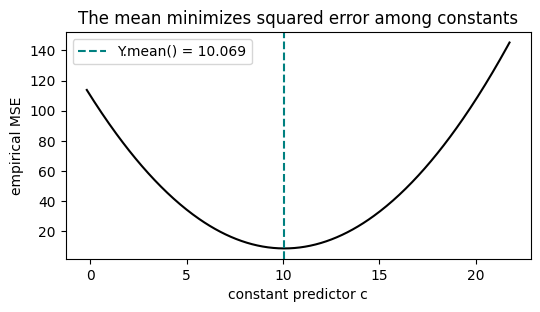

In [8]:
plt.figure(figsize=(6,3),dpi=100)

plt.plot(c_grid, mse_grid, color='k')
plt.axvline(c_hat, linestyle='--',
            label=f'Y.mean() = {c_hat:.3f}', color='teal')

plt.xlabel('constant predictor c')
plt.ylabel('empirical MSE')
plt.title('The mean minimizes squared error among constants')
plt.legend()

plt.show()

_______
### 0.2 The big theorem: conditional expectation is the best predictor (in MSE)

Now suppose you are allowed to predict $Y$ using *any function* of features $X$:

$$
\text{predict } Y \text{ with } g(X).
$$

Choose $g$ to minimize mean squared error:

$$
g^*(\cdot) = \operatorname*{argmin}_g\; \mathbb{E}\big[(Y - g(X))^2\big].
$$


**Theorem:**

$$
g^*(X) = \mathbb{E}[Y\mid X].
$$

**Interpretation:** the conditional expectation is the unique best (MSE-optimal) prediction rule.


### Proof idea (the key decomposition):

For any candidate $g(X)$,

$$
\mathbb{E}\big[(Y-g(X))^2\big]
= \mathbb{E}\big[(Y-\mathbb{E}[Y\mid X])^2\big]
+ \mathbb{E}\big[(\mathbb{E}[Y\mid X]-g(X))^2\big].
$$

- The first term is *irreducible noise* (variance around the conditional mean).
- The second term is how far your predictor is from the conditional mean.

This decomposition implies the minimum happens at $g(X)=\mathbb{E}[Y\mid X]$.




#### ...a slightly more detailed proof of the decomposition
(worth doing once, because it shows up everywhere):

Start with:

$$
\mathbb{E}[(Y-g(X))^2] = \mathbb{E}\big[\,\mathbb{E}[(Y-g(X))^2\mid X]\,\big]
$$

by the law of total expectation.

Inside the conditional expectation, treat $g(X)$ as a constant (because we are conditioning on $X$):

$$
\mathbb{E}[(Y-g(X))^2\mid X]
= \operatorname{Var}(Y\mid X) + \big(\mathbb{E}[Y\mid X]-g(X)\big)^2.
$$

This is just the identity $\mathbb{E}[(Z-a)^2]=\operatorname{Var}(Z) + (\mathbb{E}[Z]-a)^2$ applied with $Z=Y\mid X$ and $a=g(X)$.

Now take expectations again:

$$
\mathbb{E}[(Y-g(X))^2]
= \mathbb{E}[\operatorname{Var}(Y\mid X)] + \mathbb{E}\big[(\mathbb{E}[Y\mid X]-g(X))^2\big].
$$

Finally, note that:

$$
\mathbb{E}[\operatorname{Var}(Y\mid X)] = \mathbb{E}[(Y-\mathbb{E}[Y\mid X])^2],
$$

so we recover the earlier decomposition.


In [9]:
# A toy nonlinear data-generating process
n = 800
X = np.random.uniform(-3, 3, size=n)

# True conditional expectation (nonlinear)
mu = 1.0 + 0.7*X - 0.4*(X**2)

# Observed Y adds noise
Y = mu + np.random.normal(0, 1.0, size=n)

In [10]:
# 1) Best constant predictor (empirical mean)
pred_const = np.full_like(Y, Y.mean())

# 2) Linear regression predictor
lin = LinearRegression().fit(X.reshape(-1,1), Y)
pred_lin = lin.predict(X.reshape(-1,1))

# 3) Binned predictor: approximate E[Y|X] via local averages
bins = np.linspace(X.min(), X.max(), 16)
bin_id = np.digitize(X, bins) - 1
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_means = np.array([Y[bin_id==i].mean() for i in range(len(bin_centers))])
pred_bin = np.array([bin_means[i] if 0<=i<len(bin_means) else np.nan for i in bin_id])

In [11]:
mse_const = np.mean((Y - pred_const)**2)
mse_lin   = np.mean((Y - pred_lin)**2)
mse_bin   = np.nanmean((Y - pred_bin)**2)

mse_const, mse_lin, mse_bin


(3.9132747744639187, 2.2593303554128905, 1.0715903801700548)

In [12]:
# Plot: data + true conditional mean + predictors
xx = np.linspace(X.min(), X.max(), 400)
mu_xx = 1.0 + 0.7*xx - 0.4*(xx**2)

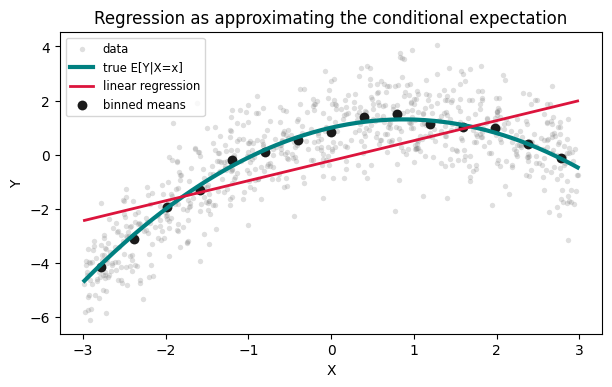

In [13]:
plt.figure(figsize=(7,4),dpi=100)

plt.scatter(X, Y, alpha=0.25, s=15, label='data', lw=0, color='.5')

plt.plot(xx, mu_xx, linewidth=3, label='true E[Y|X=x]', color='teal')
plt.plot(xx, lin.intercept_ + lin.coef_[0]*xx, linewidth=2,
         label='linear regression', color='crimson')

plt.scatter(bin_centers, bin_means, s=50, marker='o',
            label='binned means', lw=0, color='.1')

plt.title('Regression as approximating the conditional expectation')
plt.xlabel('X')
plt.ylabel('Y')

plt.legend(loc=2, fontsize='small')

plt.show()

Notice:

- The *true* object is $\mathbb{E}[Y\mid X]$ (the thick curve).
- Linear regression finds the best *linear* approximation to that curve.
- Binning creates a crude *nonparametric* approximation.

In many sports settings, binning is exactly what a "heatmap" is.


__________
## Part 1 — Expectation from the ground up
__________

Expectation is the *language* of “average outcomes under a probability model.”

You already saw it in Class 04, but today we want to connect it explicitly to regression, likelihood, and spatial metrics.




### 1.1 Random variables (what is actually random?)

A **random variable** is a function from an underlying random experiment to a number.

Formally:

$$
X : \Omega \to \mathbb{R}.
$$

The randomness comes from the outcome in $\Omega$, not from the function itself.

Sports examples:

- Shot outcome: $Y\in\{0,1\}$ (goal or not).
- Number of goals in a match: $G\in\{0,1,2,\dots\}$.
- Time to next scoring event: $T\ge 0$.
- Win indicator: $W\in\{0,1\}$.
- Points on a possession: $P\in\{0,1,2,3\}$.



### 1.2 Expectation: discrete case

If $X$ takes values in a countable set $\{x_1,x_2,\dots\}$ with probabilities $P(X=x_i)$, then:

$$
\mathbb{E}[X] = \sum_i x_i\,P(X=x_i).
$$

Think: **weighted average**.


In [14]:
# Example: fair die
faces = np.arange(1, 7)
print("a fair die with", faces, 'faces')
p = np.ones_like(faces) / 6

E_die = np.sum(faces * p)

print("average value =", E_die)

a fair die with [1 2 3 4 5 6] faces
average value = 3.5


In [15]:
# Monte Carlo check

N = 200_000
rolls = np.random.randint(1, 7, size=N)
rolls.mean()

3.49743

### 1.3 Expectation: continuous case

If $X$ has a probability density function $f(x)$, then:

$$
\mathbb{E}[X] = \int_{-\infty}^{\infty} x\,f(x)\,dx.
$$

More generally, for any function $g$:

$$
\mathbb{E}[g(X)] = \int g(x)\,f(x)\,dx.
$$

In sports, continuous ("continuous"? maybe!?) random variables show up in things like:

- sprint speed,
- shot distance,
- expected points as a continuous function of location,
- player positions (tracking data).

### 1.4 Key properties you will use pretty often

#### Linearity of expectation

For any random variables $X$ and $Y$ and constants $a,b$:

$$
\mathbb{E}[aX + bY] = a\,\mathbb{E}[X] + b\,\mathbb{E}[Y].
$$

This holds without any independence assumptions.

#### Expectation of an indicator

If $\mathbf{1}_A$ is the indicator of event $A$:

$$
\mathbb{E}[\mathbf{1}_A] = P(A).
$$

This is the core reason probabilities show up as expectations.

#### Law of total expectation (tower property)

If $X$ and $Z$ are random variables:

$$
\mathbb{E}[X] = \mathbb{E}[\,\mathbb{E}[X\mid Z]\,].
$$

Interpretation: "average of conditional averages = overall average".


In [16]:
# Quick simulation check of linearity + tower property
n = 200_000
Z = np.random.binomial(1, 0.3, size=n)  # group indicator

# X depends on Z
X = np.where(Z==1, np.random.normal(5, 1, size=n), np.random.normal(0, 1, size=n))

EX = X.mean()
EX_given_Z1 = X[Z==1].mean()
EX_given_Z0 = X[Z==0].mean()

# tower: E[X] = E[E[X|Z]] = P(Z=1)*E[X|Z=1] + P(Z=0)*E[X|Z=0]
P1 = (Z==1).mean()
P0 = 1 - P1
tower = P1*EX_given_Z1 + P0*EX_given_Z0

EX, tower


(1.5039278663762303, 1.5039278663762308)

### 1.5 Variance (because expected value is not the whole story)

Expectation gives the average, but *variance* tells you how much outcomes fluctuate.

$$
\operatorname{Var}(X) = \mathbb{E}[(X-\mathbb{E}[X])^2] = \mathbb{E}[X^2] - (\mathbb{E}[X])^2.
$$

Two important special cases:

#### Bernoulli variance

If $Y\sim\text{Bernoulli}(p)$ (so $Y\in\{0,1\}$ and $P(Y=1)=p$), then:

$$
\mathbb{E}[Y] = p,\qquad \operatorname{Var}(Y)=p(1-p).
$$

#### Sum of (independent) Bernoullis

If $G = \sum_{i=1}^n Y_i$ where $Y_i\sim\text{Bernoulli}(p_i)$ are independent, then:

$$
\mathbb{E}[G] = \sum_{i=1}^n p_i, \qquad \operatorname{Var}(G) = \sum_{i=1}^n p_i(1-p_i).
$$

That $\sum p_i$ is exactly the math behind "team xG".


In [17]:
# Example: sum of Bernoullis -> expected total successes
p = np.array([0.05, 0.10, 0.30, 0.40])

E_total = p.sum().round(10)
Var_total = np.sum(p*(1-p)).round(10)
print(E_total, Var_total)


# Monte Carlo check
N = 200_000
Y = np.random.binomial(1, p, size=(N, len(p)))
G = Y.sum(axis=1)
print(G.mean().round(10), G.var().round(10))

0.85 0.5875
0.851355 0.588149664


__________
## Part 2 — Why sports analytics loves expectation

Many widely-used sports metrics are literally conditional expectations.

A generic template:

$$
\text{Expected Value Metric at state } s \;:=\; \mathbb{E}[\text{future outcome} \mid \text{current state}=s].
$$

Where "state" could mean:

- shot location + context,
- down/distance/field position,
- base-out state in baseball,
- lineup + spacing + clock in basketball,
- score/time remaining,
- etc.


### 2.1 A small zoo of "expected" metrics (across sports)

Below are common expected-value metrics, with the minimal math definition.



#### Soccer

- **Expected goals (xG)**: $xG(\text{shot}) = P(\text{goal} \mid \text{shot features}).$
  
- **Expected goals against (xGA)**: same idea, for shots conceded.

- **Expected threat (xT)** / **possession value**: $xT(\text{action}) = \mathbb{E}[\text{future goals} \mid \text{action}] - \mathbb{E}[\text{future goals} \mid \text{no action}]$. (Note: the details vary by definition; idea is always conditional expectation.)

#### Basketball

- **Expected points (shot or possession)**: $\mathbb{E}[\text{points} \mid \text{location, defender distance, clock, …}].$
  
- **Expected possession value (EPV)** (Cervone et al.): $\mathbb{E}[\text{points scored on this possession} \mid \text{tracking state}].$

#### American football

- **Expected points (EP)** and **expected points added (EPA)**: $EP(s) = \mathbb{E}[\text{points next} \mid s],\,\, EPA = EP(s_{\text{after}}) - EP(s_{\text{before}}).$

#### Baseball

- **Run expectancy (RE)** matrix: $RE(s) = \mathbb{E}[\text{runs to end of inning} \mid \text{base-out state } s].$


Across sports, the only thing that changes is how you define the state $s$ and the outcome.


_______
### 2.2 Worked example (basketball): expected points as $\mathbb{E}[\text{points}\mid X]$

Suppose each shot has:

- location $(x,y)$,
- shot type (2pt or 3pt),
- outcome make/miss.

Define the random variable:

$$
P = \text{points scored on the shot} \in \{0,2,3\}.
$$

Then the *expected points* of a shot from context $X$ is:

$$
\mathbb{E}[P \mid X] = 2\cdot P(\text{make 2} \mid X) + 3\cdot P(\text{make 3} \mid X).
$$

Below we simulate a toy dataset and estimate a heatmap of $\mathbb{E}[P\mid (x,y)]$.


In [18]:
# --- Toy basketball shot generator ---
# Coordinate system: half-court with hoop at (0,0)
# x = left/right, y = distance from hoop (feet)

n = 8000
x = np.random.normal(0, 12, size=n)
y = np.random.uniform(0, 40, size=n)

In [19]:
# three-point line ~ 23.75 ft in NBA; we'll use a simple rule
dist = np.sqrt(x**2 + y**2)
is_three = dist > 23.75

In [20]:
# True make probabilities: decay with distance; 3pt slightly harder
p_make = np.where(is_three,
                  sigmoid(2.2 - 0.12*dist),
                  sigmoid(2.8 - 0.10*dist))

make = np.random.binomial(1, p_make)
points = make * np.where(is_three, 3, 2)

df_bball = pd.DataFrame({'x': x, 'y': y, 'dist': dist, 'is_three': is_three.astype(int),
                         'p_true': p_make, 'make': make, 'points': points})
df_bball.head()

,x,y,dist,is_three,p_true,make,points
0,14.357653,11.358002,18.307005,0,0.724980,1,2
1,-1.691675,9.149818,9.304888,0,0.866402,1,2
2,-18.106302,29.392818,34.522107,1,0.125357,0,0
3,2.829253,15.313295,15.572465,0,0.776043,1,2
4,8.176302,12.005211,14.525048,0,0.793720,0,0


In [21]:
# fun lil helper function

def draw_half_court(ax=None):
    """Draw a simple half-court for basketball shot charts.

    Coordinate system used here (toy, but common in shot-chart demos):
    - Hoop at (0, 0)
    - $x$ is left/right (feet), roughly [-25, 25]
    - $y$ is distance from hoop (feet), roughly [0, 42]

    This is intentionally minimal: it’s just enough geometry to orient a heatmap.
    """
    if ax is None:
        ax = plt.gca()

    # Hoop + backboard
    hoop = plt.Circle((0, 0), radius=0.75, fill=False)
    ax.add_patch(hoop)
    ax.plot([-3, 3], [-1, -1], linewidth=2)

    # Restricted area + three-point arc (approximate)
    ra = plt.Circle((0, 0), radius=4, fill=False)
    ax.add_patch(ra)
    arc = plt.Circle((0, 0), radius=23.75, fill=False, linestyle='--')
    ax.add_patch(arc)

    # Viewing window
    ax.set_xlim(-25, 25)
    ax.set_ylim(-2, 42)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    return ax


In [22]:
# ---------------------------------------------------------------------
# Estimate a location-based value function:
#   E[points | (x, y)]
#
# This is the direct basketball analogue of xG:
#   xG = E[goal | shot context]
# ---------------------------------------------------------------------

# 1) Define spatial bins (edges) across the half-court.
x_edges = np.linspace(-25, 25, 51)  # 50 bins left-to-right
y_edges = np.linspace(0, 42, 43)    # 42 bins out from hoop


In [23]:
# 2) Assign each shot to a bin index.
xbin = np.digitize(df_bball['x'], x_edges) - 1
ybin = np.digitize(df_bball['y'], y_edges) - 1


In [24]:
# 3) Accumulate totals per bin.
sum_points = np.zeros((len(y_edges)-1, len(x_edges)-1))
count = np.zeros_like(sum_points)

for xb, yb, pts in zip(xbin, ybin, df_bball['points']):
    # Guard against shots that fall just outside the bin edges.
    if 0 <= xb < sum_points.shape[1] and 0 <= yb < sum_points.shape[0]:
        sum_points[yb, xb] += pts
        count[yb, xb] += 1


In [25]:
# 4) Convert totals to means. Empty bins get NaN.
mean_pts = np.divide(
    sum_points,
    count,
    out=np.full_like(sum_points, np.nan),
    where=count > 0
)

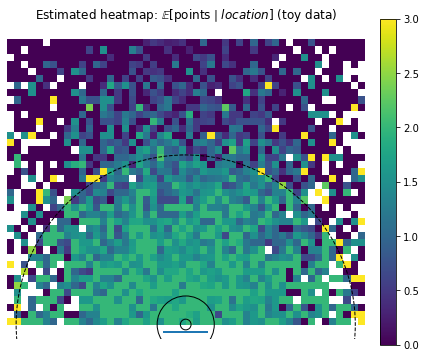

In [26]:
# 5) Plot: imshow expects row index = y, column index = x.
plt.figure(figsize=(7,6))
ax = plt.gca()
im = ax.imshow(
    mean_pts,
    origin='lower',
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
)
draw_half_court(ax)
plt.title(r'Estimated heatmap: $\mathbb{E}[\mathrm{points}\mid location]$ (toy data)')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

**Decision view:** if you can choose between a 2pt attempt with probability $p_2$ and a 3pt attempt with probability $p_3$, then:

- Expected points for 2: $2p_2$
- Expected points for 3: $3p_3$

Prefer the 3 when:

$$
3p_3 > 2p_2 \quad\Leftrightarrow\quad p_3 > \frac{2}{3}p_2.
$$

This is the sort of simple inequality that shows up in shot selection, fourth-down decisions, and tactical trade-offs.


In [27]:
p2 = np.linspace(0.3, 0.7, 200)
threshold_p3 = (2/3)*p2

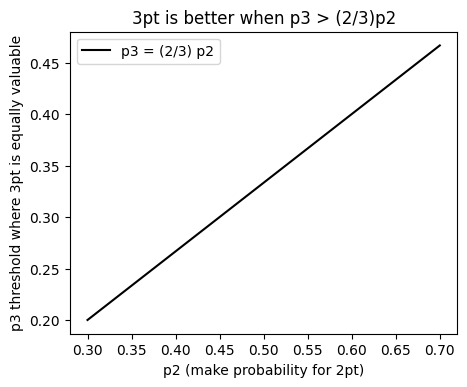

In [28]:
plt.figure(figsize=(5,4),dpi=100)

plt.plot(p2, threshold_p3, label='p3 = (2/3) p2', color='k')

plt.xlabel('p2 (make probability for 2pt)')
plt.ylabel('p3 threshold where 3pt is equally valuable')
plt.title('3pt is better when p3 > (2/3)p2')
plt.legend()

plt.show()

________
### 2.3 Worked example (baseball): run expectancy as a conditional expectation

In baseball, a classic expected-value object is **run expectancy**.

Define the *base-out state*:

- outs $\in\{0,1,2\}$,
- base occupancy (none, 1st, 2nd, 3rd, 1st+2nd, …) → 8 possibilities.

Let $R$ be the number of runs scored **from now until the end of the inning**.

Then the run expectancy for state $s$ is:

$$
RE(s) = \mathbb{E}[R \mid \text{state}=s].
$$

In real MLB analytics, $RE(s)$ is estimated from play-by-play data.
Here we’ll do a toy Monte Carlo version (not realistic baseball, just a clean illustration).


In [29]:
# --- Toy baseball inning simulator for run expectancy ---

# We encode the base state in a compact way:
#   bases = on1 + 2*on2 + 4*on3  in {0,...,7}
# where on1/on2/on3 are 0/1 indicators (runner present or not).

def decode_bases(b):
    """Decode an integer base-state code into (on1, on2, on3).

    Parameters
    ----------
    b : int
        Integer in {0,...,7} with bit pattern (on1, on2, on3).

    Returns
    -------
    tuple
        (on1, on2, on3), each in {0, 1}.
    """
    return (b & 1, (b >> 1) & 1, (b >> 2) & 1)

def encode_bases(on1, on2, on3):
    """Encode (on1, on2, on3) into an integer in {0,...,7}."""
    return int(on1) + 2*int(on2) + 4*int(on3)

def step_inning(outs, bases, event):
    """Advance the inning by one plate appearance (very simplified).

    Parameters
    ----------
    outs : int
        Current outs (0, 1, or 2).
    bases : int
        Base occupancy encoded as an integer 0..7.
    event : str
        One of {'OUT','BB','1B','2B','3B','HR'}.

    Returns
    -------
    outs_new : int
        Updated outs.
    bases_new : int
        Updated base occupancy (0..7).
    runs_scored : int
        Runs scored on the plate appearance.

    Notes
    -----
    This is deliberately simplified. The goal here is not baseball realism;
    it’s to show the *definition* of run expectancy as a conditional expectation:

        RE(state) = E[runs to inning end | state]

    where "state" is the (outs, bases) situation.
    """
    on1, on2, on3 = decode_bases(bases)
    runs = 0

    if event == 'OUT':
        outs += 1
        return outs, bases, runs

    if event == 'BB':
        # Walk: force runners if needed (very simplified).
        if on1 and on2 and on3:
            runs += 1

        new_on3 = on3 or (on2 and on1)
        new_on2 = on2 or on1
        new_on1 = 1
        return outs, encode_bases(new_on1, new_on2, new_on3), runs

    if event == '1B':
        # Single: everyone advances 1 base.
        runs += on3
        new_on3 = on2
        new_on2 = on1
        new_on1 = 1
        return outs, encode_bases(new_on1, new_on2, new_on3), runs

    if event == '2B':
        # Double: everyone advances 2 bases.
        runs += on3 + on2
        new_on3 = on1
        new_on2 = 1
        new_on1 = 0
        return outs, encode_bases(new_on1, new_on2, new_on3), runs

    if event == '3B':
        # Triple: all runners score.
        runs += on1 + on2 + on3
        return outs, encode_bases(0, 0, 1), runs

    if event == 'HR':
        # Home run: batter + all runners score.
        runs += 1 + on1 + on2 + on3
        return outs, encode_bases(0, 0, 0), runs

    raise ValueError('unknown event')


In [30]:
# Event probabilities (toy). These are not calibrated to MLB; they just make the simulator behave plausibly.
events = np.array(['OUT','BB','1B','2B','3B','HR'])
probs  = np.array([0.70, 0.08, 0.12, 0.06, 0.01, 0.03])
probs = probs / probs.sum()

def simulate_inning(start_outs=0, start_bases=0, max_pa=100):
    """Simulate the rest of an inning and return total runs scored.

    Parameters
    ----------
    start_outs : int
        Starting outs (0, 1, or 2).
    start_bases : int
        Starting base state (0..7).
    max_pa : int
        Safety cap on plate appearances (prevents rare infinite loops).

    Returns
    -------
    int
        Runs scored from this state until the inning ends.
    """
    outs = start_outs
    bases = start_bases
    runs = 0
    pa = 0

    while outs < 3 and pa < max_pa:
        event = np.random.choice(events, p=probs)
        outs, bases, r = step_inning(outs, bases, event)
        runs += r
        pa += 1

    return runs

In [31]:
# Estimate RE(out, bases) by Monte Carlo:
#   RE[out, bases] ≈ average runs to inning end, starting from that state.
n_sims = 2000
RE = np.zeros((3, 8))

for outs in range(3):
    for bases in range(8):
        runs = [simulate_inning(outs, bases) for _ in range(n_sims)]
        RE[outs, bases] = np.mean(runs)

RE_df = pd.DataFrame(
    RE,
    index=['0 outs','1 out','2 outs'],
    columns=['---','1--','-2-','12-','--3','1-3','-23','123']
)
RE_df

,---,1--,-2-,12-,--3,1-3,-23,123
0 outs,0.3725,0.6570,0.757,1.1315,0.8930,1.2645,1.3675,1.795
1 out,0.2125,0.3765,0.440,0.7625,0.6075,0.8525,0.9380,1.309
2 outs,0.0760,0.1595,0.230,0.3065,0.3045,0.4055,0.4615,0.633


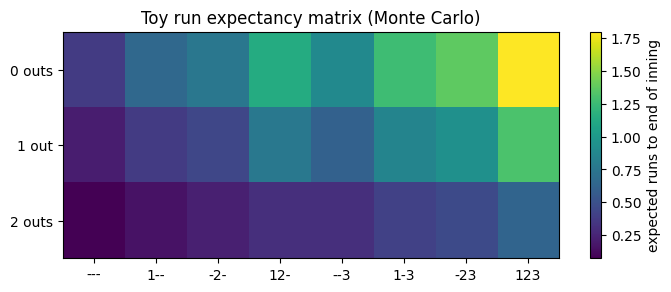

In [32]:
plt.figure(figsize=(8,3), dpi=100)

plt.imshow(RE, aspect='auto', origin='upper')

plt.yticks([0,1,2], ['0 outs','1 out','2 outs'])
plt.xticks(range(8), ['---','1--','-2-','12-','--3','1-3','-23','123'])
plt.colorbar(label='expected runs to end of inning')
plt.title('Toy run expectancy matrix (Monte Carlo)')

plt.show()

### 2.4 Worked example (American football): expected points and EPA

Football analytics often uses **expected points (EP)** to value game states.

Let $s$ denote the state (down, distance, yard line, time, score, etc.).

Define:

$$
EP(s) = \mathbb{E}[\text{net points scored on the drive or next possession} \mid s].
$$

A play moves you from state $s_{\text{before}}$ to $s_{\text{after}}$.

Then **expected points added (EPA)** is:

$$
EPA = EP(s_{\text{after}}) - EP(s_{\text{before}}).
$$

Real EP models are estimated from play-by-play data. Here’s a toy example to illustrate the expectation idea.


In [33]:
# Toy EP curve as a function of distance-to-goal (yardline from offense perspective)
yardline = np.linspace(1, 99, 99)

# Crude EP: closer to end zone -> higher expected points
# (This is just a smooth curve for illustration! probably lots of better idas)
EP = 7*sigmoid(4 - 0.08*yardline) - 2*sigmoid(-3 + 0.06*yardline)  # touchdown-ish minus safety-ish

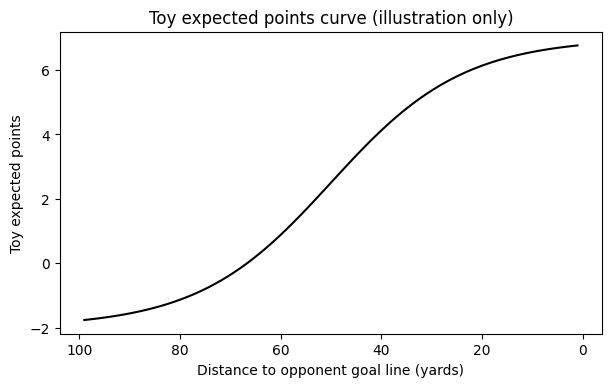

In [34]:
plt.figure(figsize=(7,4), dpi=100)

plt.plot(yardline, EP, color='k')

plt.gca().invert_xaxis()
plt.xlabel('Distance to opponent goal line (yards)')
plt.ylabel('Toy expected points')
plt.title('Toy expected points curve (illustration only)')

plt.show()

In [35]:
# Toy EPA example: a play from own 40 to opponent 45

def EP_toy(d):
    """A toy expected points curve as a function of distance to the end zone.

    Parameters
    ----------
    d : float
        Distance (in yards) from the opponent's goal line.
        Example: own 40 yard line corresponds to d=60.

    Returns
    -------
    float
        Toy expected points.

    Notes
    -----
    This is not fitted to any real league. It’s a smooth, monotone curve that
    behaves like an EP model: closer to the goal line → higher expected points.
    """
    return float(7*sigmoid(4 - 0.08*d) - 2*sigmoid(-3 + 0.06*d))

# Example field-position change
s_before = 60  # own 40 => 60 yards from opponent goal line
s_after  = 45  # opponent 45 => 45 yards from opponent goal line

# Expected Points Added (EPA) is just a difference in expectations:
EPA = EP_toy(s_after) - EP_toy(s_before)

EP_toy(s_before), EP_toy(s_after), EPA


(0.8788660196551219, 3.3396986544104825, 2.4608326347553606)

__________
## Part 3 — Heatmaps as spatial conditional expectations

A heatmap is usually a picture of a function over space.

In sports, the most useful heatmaps are usually of the form:

$$
\text{heatmap}(x,y) \approx \mathbb{E}[Y \mid (X,Y)=(x,y)].
$$

Where the letter choices are unfortunate: here $(x,y)$ are coordinates, and $Y$ is an outcome.

Three common types:

1. **Density heatmap:** $\mathbb{E}[\mathbf{1}_{\text{shot}}\mid (x,y)]$ → where actions happen.
2. **Rate heatmap:** $\mathbb{E}[\mathbf{1}_{\text{goal}}\mid (x,y),\text{shot}]$ → success rate by location.
3. **Value heatmap:** $\mathbb{E}[\text{points/goals}\mid (x,y)]$ → expected value (often model-based).

### Binning as an estimator

A simple estimator is binning:

$$
\widehat{\mathbb{E}}[Y\mid (x,y)\in\text{bin } b]
= \frac{1}{n_b}\sum_{i: (x_i,y_i)\in b} y_i.
$$

Heatmaps are just conditional expectation estimates in 2D.


In [82]:
# --- Soccer pitch drawing helper ---

def draw_pitch(ax=None, pitch_length=105, pitch_width=68):
    """Draw a simple soccer pitch (top-down).

    Parameters
    ----------
    ax : matplotlib axis, optional
        If None, draws on the current axis.
    pitch_length : float
        Length of the pitch (meters). Common default: 105.
    pitch_width : float
        Width of the pitch (meters). Common default: 68.

    Returns
    -------
    matplotlib axis
        The axis the pitch was drawn on.
    """
    if ax is None:
        ax = plt.gca()

    # Outline
    ax.plot([0, pitch_length], [0, 0], linewidth=2, color='0.8')
    ax.plot([0, pitch_length], [pitch_width, pitch_width], linewidth=2, color='0.8')
    ax.plot([0, 0], [0, pitch_width], linewidth=2, color='0.8')
    ax.plot([pitch_length, pitch_length], [0, pitch_width], linewidth=2, color='0.8')

    # Halfway line + center circle
    ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], linewidth=1, color='0.8')
    center_circle = plt.Circle((pitch_length/2, pitch_width/2), 9.15, fill=False, color='0.8')
    ax.add_patch(center_circle)

    # Penalty box (right side)
    box_w = 40.32
    box_l = 16.5
    y0 = (pitch_width - box_w)/2
    ax.plot([pitch_length, pitch_length-box_l], [y0, y0], linewidth=1, color='0.8')
    ax.plot([pitch_length-box_l, pitch_length-box_l], [y0, y0+box_w], linewidth=1, color='0.8')
    ax.plot([pitch_length-box_l, pitch_length], [y0+box_w, y0+box_w], linewidth=1, color='0.8')

    # Goal box (right side)
    gbox_w = 18.32
    gbox_l = 5.5
    y1 = (pitch_width - gbox_w)/2
    ax.plot([pitch_length, pitch_length-gbox_l], [y1, y1], linewidth=1, color='0.8')
    ax.plot([pitch_length-gbox_l, pitch_length-gbox_l], [y1, y1+gbox_w], linewidth=1, color='0.8')
    ax.plot([pitch_length-gbox_l, pitch_length], [y1+gbox_w, y1+gbox_w], linewidth=1, color='0.8')

    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    return ax

def shot_angle(x, y, goal_x=105, goal_y_center=34, goal_width=7.32):
    """Compute the (open) shooting angle to the goal mouth.

    Angle is defined as the angle (in radians) between the lines from the shot
    location to the left and right goal posts.

    Parameters
    ----------
    x, y : array-like
        Shot coordinates (meters). Here we assume the attacking goal is at x=105.
    goal_x : float
        x-location of the goal line.
    goal_y_center : float
        y-location of the goal center.
    goal_width : float
        Goal width in meters (FIFA: 7.32).

    Returns
    -------
    array-like
        Angle in radians, between 0 and pi.
    """
    y_left = goal_y_center - goal_width/2
    y_right = goal_y_center + goal_width/2

    # Vectors from shot location to each post
    v1 = np.array([goal_x - x, y_left - y])
    v2 = np.array([goal_x - x, y_right - y])

    # Angle via arccos of normalized dot product
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    norm = np.sqrt(v1[0]**2 + v1[1]**2) * np.sqrt(v2[0]**2 + v2[1]**2)

    # Numerical safety: avoid division by 0
    norm = np.maximum(norm, 1e-12)

    cosang = np.clip(dot / norm, -1, 1)
    return np.arccos(cosang)


In [83]:
# --- Generate toy soccer shots ---
# This is intentionally synthetic so the notebook runs anywhere (no external files).
n = 9000

# Shot locations biased toward the attacking third
x = np.random.beta(6, 2, size=n) * 105  # skew toward right (attacking goal)
y = np.random.beta(2, 2, size=n) * 68

# Keep only shots in the attacking half (rough realism)
mask = x > 52.5
x, y = x[mask], y[mask]

In [84]:
# Simple geometric features: distance and angle to goal
dist = np.sqrt((105 - x)**2 + (34 - y)**2)
ang = shot_angle(x, y)

# "True" goal probability: larger angle + smaller distance => higher p
# (This defines the toy data-generating process.)
p_true = sigmoid(1.5 + 1.8*np.log(ang + 1e-6) - 0.12*dist)

goal = np.random.binomial(1, p_true)

df_soc = pd.DataFrame({
    'x': x,
    'y': y,
    'dist': dist,
    'angle': ang,
    'p_true': p_true,
    'goal': goal
})
df_soc.head()


,x,y,dist,angle,p_true,goal
0,97.093206,25.954094,11.280692,0.470290,0.229416,1
1,81.014431,32.774866,24.016837,0.302089,0.028287,0
2,85.384219,50.588009,25.689315,0.218537,0.013123,0
3,55.831552,12.327518,53.732977,0.124589,0.000167,0
4,68.683402,51.698926,40.399842,0.162771,0.001337,0


In [85]:
# Bin the pitch and compute density + goal rate
x_edges = np.linspace(52.5, 105, 54)   # focus attacking half
y_edges = np.linspace(0, 68, 35)

xi = np.digitize(df_soc['x'], x_edges) - 1
yi = np.digitize(df_soc['y'], y_edges) - 1

shot_counts = np.zeros((len(y_edges)-1, len(x_edges)-1))
goal_counts = np.zeros_like(shot_counts)

for xb, yb, g in zip(xi, yi, df_soc['goal']):
    if 0 <= xb < shot_counts.shape[1] and 0 <= yb < shot_counts.shape[0]:
        shot_counts[yb, xb] += 1
        goal_counts[yb, xb] += g

with np.errstate(invalid='ignore', divide='ignore'):
    goal_rate = goal_counts / shot_counts


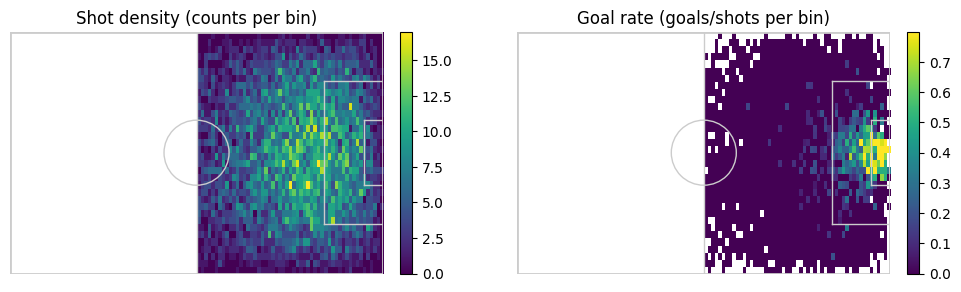

In [86]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(12,3.2), dpi=100)

im0 = axes[0].imshow(shot_counts, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
draw_pitch(axes[0])
axes[0].set_title('Shot density (counts per bin)')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(goal_rate, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], vmin=0, vmax=np.nanpercentile(goal_rate, 99))
draw_pitch(axes[1])
axes[1].set_title('Goal rate (goals/shots per bin)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()


### 3.1 Binning is an estimator (so it has bias/variance trade-offs)

Heatmaps can look very different depending on bin size:

- Small bins: high spatial resolution, but high noise (few shots per bin).
- Large bins: smoother estimates, but can blur structure.

This is exactly the usual statistical trade-off.


In [87]:
def binned_goal_rate(df, x_edges, y_edges):
    """Estimate goal rate in spatial bins.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have columns ['x', 'y', 'goal'].
    x_edges, y_edges : array-like
        Bin edges for x and y.

    Returns
    -------
    rate : 2D array
        Estimated goal rate per bin (goals / shots). Empty bins are NaN.
    shots : 2D array
        Shot counts per bin.

    Notes
    -----
    Goal rate heatmaps are intuitive, but they can be noisy in low-count bins.
    Later we’ll connect this to the bias/variance tradeoff (bin size vs smoothness).
    """
    xi = np.digitize(df['x'], x_edges) - 1
    yi = np.digitize(df['y'], y_edges) - 1

    shots = np.zeros((len(y_edges)-1, len(x_edges)-1))
    goals = np.zeros_like(shots)

    for xb, yb, g in zip(xi, yi, df['goal']):
        if 0 <= xb < shots.shape[1] and 0 <= yb < shots.shape[0]:
            shots[yb, xb] += 1
            goals[yb, xb] += g

    rate = np.divide(
        goals,
        shots,
        out=np.full_like(goals, np.nan),
        where=shots > 0
    )
    return rate, shots


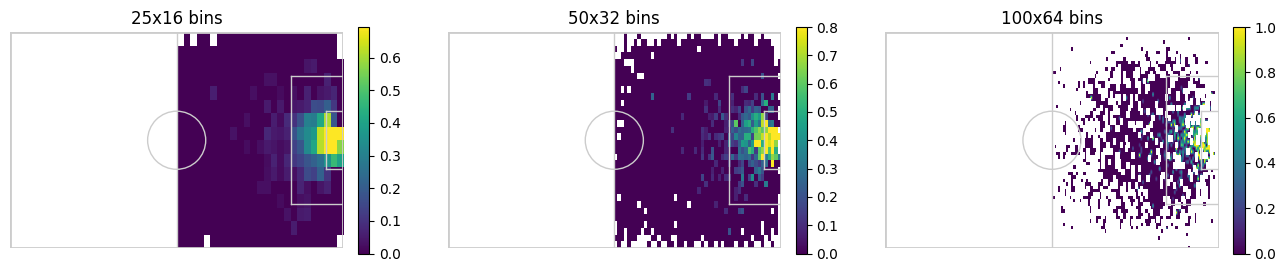

In [88]:
# A quick sensitivity check: bin resolution changes what you "see".
fig, axes = plt.subplots(1, 3, figsize=(16,3), dpi=100)
bin_specs = [(25, 16), (50, 32), (100, 64)]

for ax, (nx, ny) in zip(axes, bin_specs):
    x_edges = np.linspace(52.5, 105, nx+1)
    y_edges = np.linspace(0, 68, ny+1)

    rate, shots = binned_goal_rate(df_soc, x_edges, y_edges)

    # Clip the color scale to avoid a few extreme bins dominating the colormap.
    vmax = np.nanpercentile(rate, 99)

    im = ax.imshow(
        rate,
        origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=0,
        vmax=vmax
    )
    draw_pitch(ax)
    ax.set_title(f'{nx}x{ny} bins')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


plt.show()

### 3.2 Kernel density estimation (KDE) for smoother density heatmaps

Instead of hard bins, you can use **kernel smoothing**.

A KDE estimates a smooth density function:

$$
\hat f(x,y) = \frac{1}{n h^2}\sum_{i=1}^n K\Big(\frac{x-x_i}{h},\frac{y-y_i}{h}\Big)
$$

where $K$ is a kernel (often Gaussian) and $h$ is a bandwidth (smoothing parameter).

Below: a KDE shot density map (toy shots).


In [89]:
# KDE density for soccer shot locations
xy = np.vstack([df_soc['x'].values, df_soc['y'].values])
kde = gaussian_kde(xy)

xx = np.linspace(52.5, 105, 120)
yy = np.linspace(0, 68, 80)
Xg, Yg = np.meshgrid(xx, yy)
grid_coords = np.vstack([Xg.ravel(), Yg.ravel()])
density = kde(grid_coords).reshape(Yg.shape)

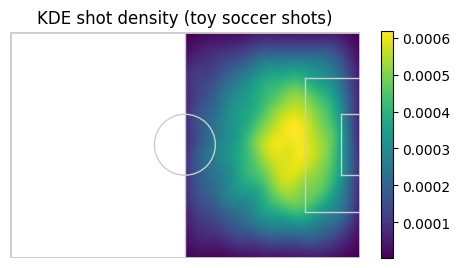

In [90]:
plt.figure(figsize=(7,3),dpi=100)

ax = plt.gca()
im = ax.imshow(density, origin='lower', extent=[xx[0], xx[-1], yy[0], yy[-1]])
draw_pitch(ax)
plt.title('KDE shot density (toy soccer shots)')
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.show()

__________
## Part 4 — Likelihoods! (hopefully step by step)

If expectation is the language of "average outcomes under a model", then **likelihood** is the language of "fit the model to the data".

### 4.1 Probability vs likelihood

- **Probability** is a function of outcomes given parameters:
  $$P(\text{data} \mid \theta).$$
- **Likelihood** is the *same expression*, but viewed as a function of parameters given fixed data:
  $$L(\theta) = P(\text{data} \mid \theta).$$

Same formula, different question.


### 4.2 Why do we care?

Because many estimators in stats/ML are obtained by:

$$
\hat\theta = \operatorname*{argmax}_\theta\; L(\theta).
$$

This is **maximum likelihood estimation** (MLE).


### 4.3 Coin flips / Bernoulli likelihood (the simplest MLE)

Suppose we observe $n$ Bernoulli trials $Y_1,\dots,Y_n$ where:

$$
P(Y_i=1) = p, \quad P(Y_i=0)=1-p.
$$

If we see $k$ successes (1s) and $n-k$ failures (0s), the likelihood is:

$$
L(p) = p^k (1-p)^{n-k}.
$$

Because we multiply probabilities across independent trials.


#### Log-likelihood

Products are annoying; logs turn products into sums.

$$
\ell(p) = \log L(p) = k\log p + (n-k)\log(1-p).
$$

MLE solves:

$$
\hat p = \operatorname*{argmax}_{p\in(0,1)}\;\ell(p).
$$

The calculus result is the familiar one:

$$
\hat p = \frac{k}{n}.
$$

Let’s verify numerically.


In [91]:
n = 40
k = 13

p_grid = np.linspace(1e-4, 1-1e-4, 2000)
loglik = k*np.log(p_grid) + (n-k)*np.log(1-p_grid)


p_hat_grid = p_grid[np.argmax(loglik)]
p_hat_closed = k/n
p_hat_grid, p_hat_closed

(0.32519754877438717, 0.325)

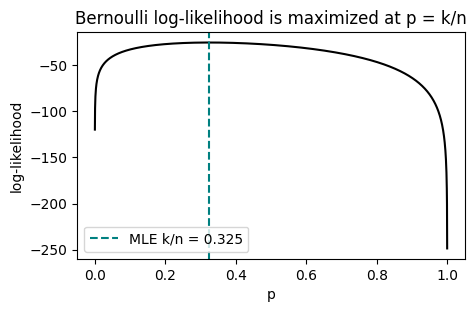

In [92]:
plt.figure(figsize=(5,3),dpi=100)

plt.plot(p_grid, loglik, color='k')
plt.axvline(p_hat_closed, linestyle='--', label=f'MLE k/n = {p_hat_closed:.3f}', color='teal')
plt.xlabel('p')
plt.ylabel('log-likelihood')
plt.title('Bernoulli log-likelihood is maximized at p = k/n')
plt.legend()

plt.show()

**Derivatives (worth seeing once):**

$$
\ell(p) = k\log p + (n-k)\log(1-p)
$$

First derivative:

$$
\frac{d\ell}{dp} = \frac{k}{p} - \frac{n-k}{1-p}.
$$

Set to zero:

$$
\frac{k}{p} = \frac{n-k}{1-p} \Rightarrow k(1-p)=(n-k)p \Rightarrow k=np \Rightarrow \hat p = \frac{k}{n}.
$$

Second derivative:

$$
\frac{d^2\ell}{dp^2} = -\frac{k}{p^2} - \frac{n-k}{(1-p)^2} < 0.
$$

Negative second derivative means the log-likelihood is concave (single maximum).



### 4.4 Normal likelihood (and why squared error appears everywhere)

Suppose:

$$
Y_1,\dots,Y_n \stackrel{\text{iid}}{\sim} \mathcal{N}(\mu,\sigma^2).
$$

The likelihood is:

$$
L(\mu,\sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}\exp\Big(-\frac{(y_i-\mu)^2}{2\sigma^2}\Big).
$$

Log-likelihood:

$$
\ell(\mu,\sigma^2)
= -\frac{n}{2}\log(2\pi\sigma^2)
- \frac{1}{2\sigma^2}\sum_{i=1}^n (y_i-\mu)^2.
$$

Key observation: for fixed $\sigma^2$, maximizing $\ell$ in $\mu$ is the same as minimizing:

$$
\sum_{i=1}^n (y_i-\mu)^2.
$$

So **least squares** emerges from a **Gaussian noise model**.


In [93]:
# Simulate normal data and show MLE for mu is the sample mean
n = 200
mu_true, sigma_true = 4.0, 2.0
y = np.random.normal(mu_true, sigma_true, size=n)

mu_grid = np.linspace(mu_true-3, mu_true+3, 400)
loglik_mu = np.array([np.sum(-0.5*((y-mu)**2)/(sigma_true**2)) for mu in mu_grid])

mu_hat_grid = mu_grid[np.argmax(loglik_mu)]
mu_hat_sample = y.mean()

mu_hat_grid, mu_hat_sample

(3.9022556390977443, 3.903873128140973)

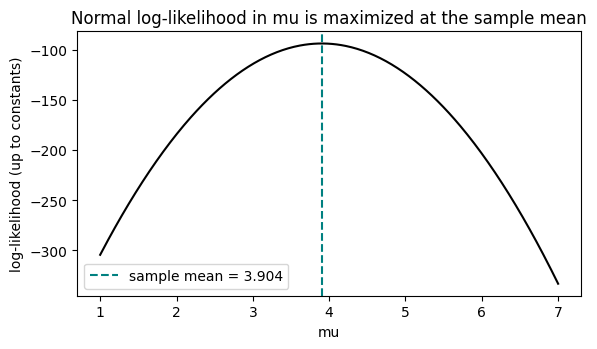

In [94]:
plt.figure(figsize=(6.5,3.5),dpi=100)

plt.plot(mu_grid, loglik_mu, color='k')
plt.axvline(y.mean(), linestyle='--', label=f'sample mean = {y.mean():.3f}', color='teal')

plt.xlabel('mu')
plt.ylabel('log-likelihood (up to constants)')
plt.title('Normal log-likelihood in mu is maximized at the sample mean')
plt.legend()

plt.show()

### 4.5 Poisson likelihood (counts) and Poisson regression

Many sports outcomes are **counts**: goals in soccer, runs in baseball, points in hockey periods, etc.

A baseline count model is the Poisson distribution:

$$
G \sim \text{Poisson}(\lambda).
$$

PMF:

$$
P(G=k) = e^{-\lambda}\frac{\lambda^k}{k!},\qquad k=0,1,2,\dots
$$

Key expectations:

$$
\mathbb{E}[G]=\lambda,\qquad \operatorname{Var}(G)=\lambda.
$$


#### Poisson MLE

If we observe counts $g_1,\dots,g_n$ i.i.d. Poisson($\lambda$), then the log-likelihood is:

$$
\ell(\lambda) = \sum_{i=1}^n \Big(-\lambda + g_i\log\lambda - \log(g_i!)\Big).
$$

Differentiate and set to zero:

$$
\frac{d\ell}{d\lambda} = \sum_{i=1}^n\Big(-1 + \frac{g_i}{\lambda}\Big) = 0
\Rightarrow \hat\lambda = \frac{1}{n}\sum_{i=1}^n g_i.
$$

So the MLE for $\lambda$ is the sample mean.


#### Poisson regression (GLM)

To make $\lambda$ depend on features $x_i$, a common model is:

$$
\log \lambda_i = \beta_0 + x_i^\top\beta.
$$

This is a **generalized linear model** (GLM). It models the *conditional expectation*:

$$
\mathbb{E}[G_i\mid x_i] = \lambda_i.
$$


In [95]:
# Poisson MLE demo
n = 400
lam_true = 1.7
g = np.random.poisson(lam_true, size=n)

lam_hat = g.mean()

In [96]:
# grid check
lam_grid = np.linspace(0.01, 5, 400)
loglik = np.array([np.sum(-lam + g*np.log(lam)) for lam in lam_grid])  # drop constants
lam_grid[np.argmax(loglik)], lam_hat

(1.6733333333333333, 1.6725)

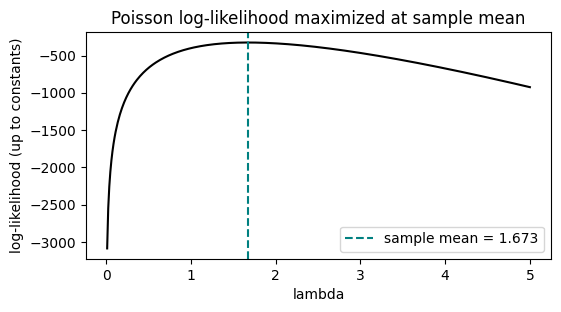

In [97]:
plt.figure(figsize=(6,3), dpi=100)

plt.plot(lam_grid, loglik, color='k')
plt.axvline(lam_hat, linestyle='--', label=f'sample mean = {lam_hat:.3f}', color='teal')
plt.xlabel('lambda')
plt.ylabel('log-likelihood (up to constants)')
plt.title('Poisson log-likelihood maximized at sample mean')
plt.legend()

plt.show()

In [98]:
# Poisson regression demo (toy): goals depend on xG-like covariate
n = 2000
xg = np.random.uniform(0.2, 2.5, size=n)  # pretend this is team xG in a match

# True relationship: lambda increases with xG (roughly linear here, but we use log-link)
lam = np.exp(-0.2 + 0.6*np.log(xg))
goals = np.random.poisson(lam)

df = pd.DataFrame({'goals': goals, 'xg': xg, 'log_xg': np.log(xg)})

In [99]:
glm_poisson = sm.GLM(df['goals'], sm.add_constant(df[['log_xg']]), family=sm.families.Poisson()).fit()
glm_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2466.3
Date:                Sat, 07 Feb 2026   Deviance:                       2225.5
Time:                        07:57:52   Pearson chi2:                 2.00e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07990
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1942      0.027     -7.284      0.000      -0.246      -0.142
log_xg         0.5176      0.042     12.211      0.000       0.435       0.601
==============================================================================
"""

### 4.6 OLS as maximum likelihood (Gaussian regression model)

Assume a linear model with Gaussian noise:

$$
Y = X\beta + \varepsilon,\qquad \varepsilon \sim \mathcal{N}(0, \sigma^2 I).
$$

That implies:

$$
Y \mid X \sim \mathcal{N}(X\beta,\,\sigma^2 I).
$$

The log-likelihood (up to constants) is:

$$
\ell(\beta,\sigma^2)
= -\frac{1}{2\sigma^2}\,(y - X\beta)^\top (y - X\beta) - \frac{n}{2}\log\sigma^2 + \text{const}.
$$

For fixed $\sigma^2$, maximizing $\ell$ over $\beta$ is equivalent to minimizing:

$$
(y - X\beta)^\top (y - X\beta) = \sum_{i=1}^n (y_i - x_i^\top\beta)^2.
$$

So OLS is an MLE under a Gaussian noise assumption.


In [100]:
# Simulate a linear regression DGP and fit with both sklearn and statsmodels
n = 500
X1 = np.random.normal(size=n)
X2 = np.random.normal(size=n)

beta0, beta1, beta2 = 1.0, 2.0, -1.5
sigma = 1.0
y = beta0 + beta1*X1 + beta2*X2 + np.random.normal(0, sigma, size=n)

X = np.column_stack([np.ones(n), X1, X2])

In [101]:
# closed-form OLS
beta_hat = np.linalg.inv(X.T@X) @ (X.T@y)

# statsmodels
model = sm.OLS(y, X).fit()

beta_hat, model.params

(array([ 0.99538857,  2.02016907, -1.33243737]),
 array([ 0.99538857,  2.02016907, -1.33243737]))

In [102]:
def nll_gaussian(beta, y, X, sigma=1.0):
    """Gaussian negative log-likelihood (up to an additive constant).

    Model:
        $$y = X\beta + \varepsilon,$$
    with
        $$\varepsilon \sim \mathcal{N}(0, \sigma^2 I).$$

    The full negative log-likelihood includes constants, but for comparing
    different $\beta$ values, the key term is proportional to:

        $$\sum_i (y_i - x_i^\top\beta)^2.$$

    Parameters
    ----------
    beta : array-like
        Coefficient vector.
    y : array-like
        Outcome vector.
    X : array-like
        Design matrix.
    sigma : float
        Noise standard deviation.

    Returns
    -------
    float
        Negative log-likelihood (dropping constants).
    """
    resid = y - X @ beta
    return 0.5 * np.sum(resid**2) / (sigma**2)

In [103]:
# Compare negative log-likelihood (Gaussian) across beta values near the optimum

beta0_grid = np.linspace(beta_hat[0]-1, beta_hat[0]+1, 200)
nll0 = [
    nll_gaussian(np.array([b0, beta_hat[1], beta_hat[2]]), y, X, sigma=sigma)
    for b0 in beta0_grid
]

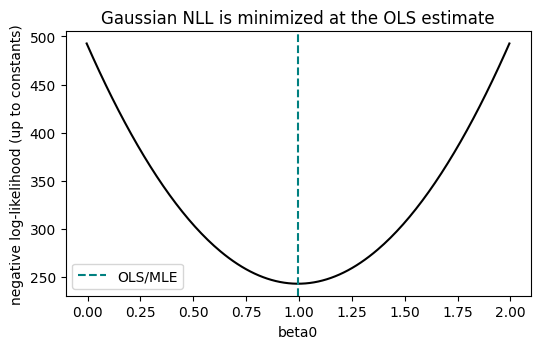

In [104]:
plt.figure(figsize=(6,3.5), dpi=100)

plt.plot(beta0_grid, nll0, color='k')
plt.axvline(beta_hat[0], linestyle='--', label='OLS/MLE', color='teal')

plt.xlabel('beta0')
plt.ylabel('negative log-likelihood (up to constants)')
plt.title('Gaussian NLL is minimized at the OLS estimate')
plt.legend()

plt.show()

__________
## Part 5 — Logistic regression (Bernoulli likelihood) 

Linear regression is great for numeric outcomes, but it can produce nonsense for probabilities (values < 0 or > 1).

For binary outcomes like goals, we want a model that:

- outputs numbers in $[0,1]$,
- connects naturally to likelihood.

### 5.1 Bernoulli model for goals

For a shot $i$, let:

$$
Y_i = \begin{cases}
1 & \text{goal}\\
0 & \text{no goal}
\end{cases}
$$

and model:

$$
Y_i \mid x_i \sim \text{Bernoulli}(p_i),\qquad p_i = P(Y_i=1\mid x_i).
$$


### 5.2 Logistic link

Logistic regression parameterizes $p_i$ as:

$$
p_i = \sigma(\eta_i) = \frac{1}{1+e^{-\eta_i}},\qquad \eta_i = \beta_0 + x_i^\top\beta.
$$

This ensures $p_i\in(0,1)$.


### 5.3 Likelihood and log-likelihood

For independent shots $i=1,\dots,n$:

$$
L(\beta) = \prod_{i=1}^n p_i^{y_i}(1-p_i)^{1-y_i}.
$$

Log-likelihood:

$$
\ell(\beta) = \sum_{i=1}^n \Big(y_i\log p_i + (1-y_i)\log(1-p_i)\Big).
$$

MLE chooses:

$$
\hat\beta = \operatorname*{argmax}_\beta\; \ell(\beta).
$$


### 5.4 Negative log-likelihood = log loss

The negative average log-likelihood is the **log loss** (a.k.a. cross-entropy loss):

$$
\text{LogLoss} = -\frac{1}{n}\sum_{i=1}^n \Big(y_i\log p_i + (1-y_i)\log(1-p_i)\Big).
$$

This is why log loss is the default evaluation metric for probabilistic classifiers.


### 5.5 Gradient (optional but useful)

For logistic regression, one very useful identity is:

$$
\nabla_\beta\,\ell(\beta) = X^\top (y - p),
$$

where $p$ is the vector of predicted probabilities.

This is the foundation of gradient-based fitting algorithms.


### 5.6 Fit a logistic regression xG model on toy soccer shots

We’ll treat the toy soccer shots from Part 3 as our dataset.

Features:

- distance to goal (meters)
- shot angle (radians)

A common modeling trick is to use $\log(\text{angle})$ because angle is bounded and strongly nonlinear.

Our model:

$$
\log\frac{p_i}{1-p_i} = \beta_0 + \beta_1\,\log(\text{angle}_i) + \beta_2\,\text{distance}_i.
$$

Then $p_i$ is the xG for shot $i$.


In [59]:
# Build design matrix for logistic regression
X_feat = np.column_stack([
    np.log(df_soc['angle'].values + 1e-9),
    df_soc['dist'].values
])
y_soc = df_soc['goal'].values

In [60]:
# sklearn logistic regression (no regularization for clarity)
clf = LogisticRegression(penalty='none', solver='lbfgs', max_iter=2000)
clf.fit(X_feat, y_soc)

beta0_skl = clf.intercept_[0]
beta_skl = clf.coef_[0]
beta0_skl, beta_skl

(1.5668862289551768, array([ 1.67666021, -0.12787254]))

In [61]:
# statsmodels logistic regression (gives standard errors)
X_sm = sm.add_constant(X_feat)
logit_model = sm.Logit(y_soc, X_sm).fit(disp=False)
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8461
Model:                          Logit   Df Residuals:                     8458
Method:                           MLE   Df Model:                            2
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:                  0.4138
Time:                        07:56:48   Log-Likelihood:                -1077.3
converged:                       True   LL-Null:                       -1837.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5669      0.141     11.149      0.000       1.291       1.842
x1             1.6767      0.211      7.952      0.000       1.263       2.090
x2            -0.1279      0.016     -8.132      0.000      -0.159      -0.097
==============================================================================
"""

In [62]:
# Predicted probabilities (xG) and evaluation
p_hat = logit_model.predict(X_sm)

ll = log_loss(y_soc, p_hat)
brier = brier_score_loss(y_soc, p_hat)

# AUC is optional; can be informative but not a probability quality measure
auc = roc_auc_score(y_soc, p_hat)

ll, brier, auc

(0.12732849012589154, 0.03566348631133738, 0.9272116951450705)

**Interpretation:**

- Log loss is the negative log-likelihood per observation (lower is better).
- Brier score is the mean squared error for probabilities (lower is better).
- AUC measures ranking/discrimination, not calibration.


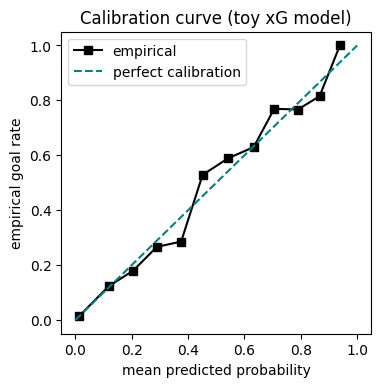

In [63]:
# Calibration curve
frac_pos, mean_pred = calibration_curve(y_soc, p_hat, n_bins=12, strategy='uniform')

plt.figure(figsize=(4,4),dpi=100)

plt.plot(mean_pred, frac_pos, marker='s', label='empirical', color='k')
plt.plot([0,1],[0,1], linestyle='--', label='perfect calibration', color='teal')
plt.xlabel('mean predicted probability')
plt.ylabel('empirical goal rate')
plt.title('Calibration curve (toy xG model)')
plt.legend()

plt.show()

### 5.7 xG as an expectation (linearity of expectation)

For shots $i=1,\dots,n$, define random variables:

$$
Y_i = \mathbf{1}_{\{\text{goal on shot } i\}}.
$$

Then the total goals scored is:

$$
G = \sum_{i=1}^n Y_i.
$$

If $p_i = P(Y_i=1\mid x_i)$, then:

$$
\mathbb{E}[G\mid x_1,\dots,x_n] = \sum_{i=1}^n \mathbb{E}[Y_i\mid x_i] = \sum_{i=1}^n p_i.
$$

This is why **team xG is a sum of per-shot probabilities**.


In [64]:
total_goals = y_soc.sum()
total_xg = p_hat.sum()
total_goals, total_xg

(478, 478.0)

Two additional useful calculations (often forgotten):

#### Variance (under independence assumption)

If shots were independent Bernoullis (approximation), then:

$$
\operatorname{Var}(G) = \sum_{i=1}^n p_i(1-p_i).
$$

#### Probability of scoring at least one goal (under independence)

$$
P(G\ge 1) = 1 - \prod_{i=1}^n (1-p_i).
$$

These are useful for match-level probabilities.


In [65]:
var_goals = np.sum(p_hat*(1-p_hat))
prob_at_least_one = 1 - np.prod(1 - p_hat[:20])  # first 20 shots as a toy 'set'
var_goals, prob_at_least_one


(301.533056321954, 0.9147328083657507)

### 5.8 From xG to match outcomes: a Poisson scoreline model (classic soccer analytics)

A common next step is to turn expected goals into **match-level probabilities**.

A classic baseline model assumes goals for each team are independent Poisson random variables:

$$
G_H \sim \text{Poisson}(\lambda_H),\qquad G_A \sim \text{Poisson}(\lambda_A).
$$

where $\lambda_H$ and $\lambda_A$ are the teams' expected goals (often proxied by xG).

Recall the Poisson PMF:

$$
P(G=k) = e^{-\lambda}\frac{\lambda^k}{k!},\qquad k=0,1,2,\dots
$$

and the key expectation:

$$
\mathbb{E}[G] = \lambda.
$$

Once you have a joint distribution for $(G_H, G_A)$, you can compute:

- $P(\text{home win}) = P(G_H > G_A)$
- $P(\text{draw}) = P(G_H = G_A)$
- $P(\text{away win}) = P(G_H < G_A)$

and even **expected points**:

$$
\mathbb{E}[\text{points}] = 3\,P(\text{win}) + 1\,P(\text{draw}).
$$

This is a useful bridge from shot-level models to table-level forecasting.


In [66]:
from scipy.stats import poisson

def match_outcome_probs(lam_home, lam_away, max_goals=10):
    """Match outcome probabilities from a simple Poisson scoreline model.

    Assumptions (classic baseline):
    - Home goals: $G_H \sim \mathrm{Poisson}(\lambda_H)$
    - Away goals: $G_A \sim \mathrm{Poisson}(\lambda_A)$
    - Independence: $G_H \perp G_A$

    Parameters
    ----------
    lam_home, lam_away : float
        Expected goals (means) for home and away.
    max_goals : int
        We truncate the grid to 0..max_goals for each team.

    Returns
    -------
    dict
        Includes win/draw/loss probabilities, expected points, the joint matrix,
        and the truncation mass (how much probability is inside the grid).
    """
    ks = np.arange(0, max_goals + 1)

    pmf_home = poisson.pmf(ks, lam_home)
    pmf_away = poisson.pmf(ks, lam_away)

    # Joint scoreline probabilities P(GH=k, GA=j)
    joint = np.outer(pmf_home, pmf_away)

    # In this matrix: rows = home goals, cols = away goals.
    p_home_win = np.tril(joint, k=-1).sum()  # below diagonal => home goals > away goals
    p_draw = np.trace(joint)
    p_away_win = np.triu(joint, k=1).sum()

    # Probability mass inside the truncation window.
    # If this is much less than 1, increase max_goals.
    p_trunc = joint.sum()

    exp_points_home = 3*p_home_win + 1*p_draw
    exp_points_away = 3*p_away_win + 1*p_draw

    return {
        'p_home_win': p_home_win,
        'p_draw': p_draw,
        'p_away_win': p_away_win,
        'p_trunc_mass': p_trunc,
        'exp_points_home': exp_points_home,
        'exp_points_away': exp_points_away,
        'joint': joint,
        'ks': ks,
    }

In [67]:
out = match_outcome_probs(lam_home=1.6, lam_away=1.1, max_goals=10)
{k: out[k] for k in ['p_home_win','p_draw','p_away_win','p_trunc_mass','exp_points_home','exp_points_away']}

{'p_home_win': 0.4895725122193909,
 'p_draw': 0.24891098064141337,
 'p_away_win': 0.2615154560560747,
 'p_trunc_mass': 0.9999989489168789,
 'exp_points_home': 1.7176285172995862,
 'exp_points_away': 1.0334573488096375}

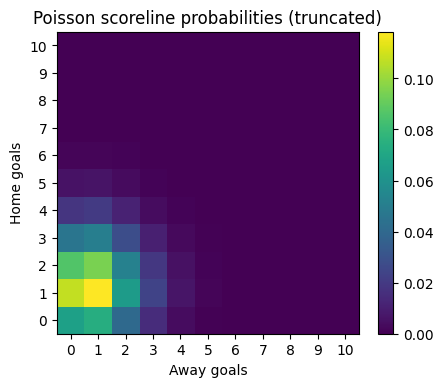

In [68]:
# Visualize the scoreline probability table
joint = out['joint']
ks = out['ks']

plt.figure(figsize=(5,4),dpi=100)

plt.imshow(joint, origin='lower')
plt.xticks(range(len(ks)), ks)
plt.yticks(range(len(ks)), ks)
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.title('Poisson scoreline probabilities (truncated)')
plt.colorbar()

plt.show()

**Limitations (important):**

- Independence of team goal counts is an approximation.
- Poisson assumes equal mean and variance; real goal distributions can be overdispersed.
- Using xG as $\lambda$ is sensible, but only if your xG model is well-calibrated and stable.

But as a teaching/first-pass model, Poisson scorelines are extremely useful.


### 5.9 xG surfaces (model-based heatmaps)

A common visualization is an **xG map**: evaluate the fitted model on a grid of locations.

This is a model-based heatmap of $P(\text{goal}\mid x,y)$.


In [69]:
# Compute predicted xG on a grid of pitch locations (attacking half)
xx = np.linspace(52.5, 105, 160)
yy = np.linspace(0, 68, 100)
Xg, Yg = np.meshgrid(xx, yy)

dist_g = np.sqrt((105 - Xg)**2 + (34 - Yg)**2)
ang_g = shot_angle(Xg, Yg)

X_feat_g = np.column_stack([
    np.log(ang_g.ravel() + 1e-9),
    dist_g.ravel()
])
X_sm_g = sm.add_constant(X_feat_g)
p_grid = logit_model.predict(X_sm_g).reshape(Yg.shape)

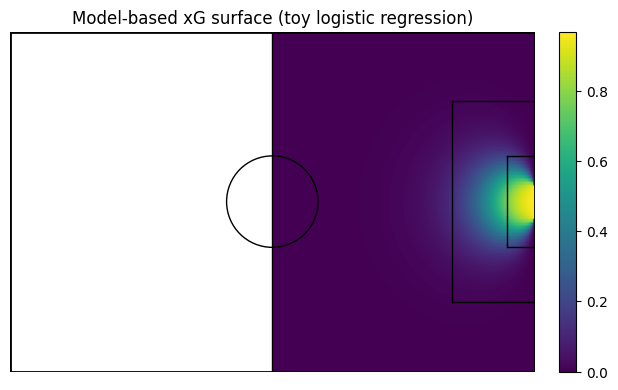

In [70]:
plt.figure(figsize=(8,4.5), dpi=100)

ax = plt.gca()
im = ax.imshow(p_grid, origin='lower', extent=[xx[0], xx[-1], yy[0], yy[-1]])
draw_pitch(ax)
plt.title('Model-based xG surface (toy logistic regression)')
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.show()

__________
## Part 6 — Expected goals (xG): definition, history, variations

### 6.1 Definition (mathematically)

For each shot $i$, an xG model outputs a probability:

$$
p_i = P(\text{goal on shot } i \mid \text{shot context}).
$$

Then total expected goals over a set of shots is:

$$
xG = \sum_{i=1}^n p_i.
$$

That’s it.


### 6.2 Interpretation (what xG is and is not)

- If a shot has xG $=0.30$, that does **not** mean it has a 30% chance *in some metaphysical sense*.
- It means: *in historical data, shots with similar features were scored about 30% of the time,* according to the model.

### 6.3 History (very incomplete, but useful)

There is genuine debate about "who invented xG".

A simple story arc (with pointers):

1. **Shot quality models** appear in academic work well before the metric was popular.
   - Example: Ensum, Pollard & Taylor (2004) used logistic regression and found factors like distance and angle matter.
2. The term **"expected goals"** appears in multiple places over time.
   - Wikipedia summarizes several early references and related threads.
3. In the **2010s**, expected goals became a standard public-facing metric.
   - Public soccer analytics sites (and later broadcast graphics) helped bring it mainstream.
   - A readable narrative is in *These Football Times* (2020).


### 6.4 Why different providers give different xG for the same shot

xG is *model-based*.

Providers can differ in:

- event definitions (what counts as a shot, assist type, etc.)
- available features (event data vs tracking / freeze-frame)
- model family (logistic regression vs gradient boosting vs neural nets)
- training data sample and labeling choices

So xG values are comparable **within a provider**, but not necessarily identical across providers.


### 6.5 Variations you will see in the wild

Here are common variants and why they exist.

#### Non-penalty xG (npxG)

Penalties have unusually high and stable conversion rates, and they don’t reflect open-play chance creation.

$$
\text{npxG} = \text{xG} - \text{xG from penalties}.
$$

#### Post-shot xG (PSxG, xGOT)

Standard xG is usually **pre-shot**: it depends on *where/how the shot was taken*.

Post-shot metrics incorporate *where the shot went in the goalmouth* (shot placement) and sometimes shot speed.

Intuition:

- Pre-shot xG: chance quality before the kick.
- Post-shot xG: chance quality + finishing execution.

Stats Perform describes xGOT as a post-shot model built on on-target shots that includes goalmouth location.

#### Expected assists (xA)

Analogous to xG, but for passes:

$$
xA(\text{pass}) = \mathbb{E}[\text{goals from the resulting shot} \mid \text{pass context}].
$$

Different providers define xA differently (what counts as a "key pass", whether rebounds count, etc.).



__________
## Part 7 — Likelihood, loss functions, and scoring rules


One reason likelihood is so central is that it connects statistical modeling to optimization.

### 7.1 From likelihood to a loss function

MLE maximizes $L(\theta)$ or equivalently maximizes $\ell(\theta)=\log L(\theta)$.

Equivalently, it *minimizes* negative log-likelihood:

$$
\hat\theta = \operatorname*{argmin}_\theta\; \big(-\ell(\theta)\big).
$$

In ML language, $-\ell(\theta)$ is a **loss function**.


### 7.2 Proper scoring rules (why log loss is special)

When you output probabilities, you need a rule to score predictions.

A scoring rule $S(p,y)$ is **proper** if (in expectation) you minimize it by predicting the true probability.

Two famous proper scoring rules for binary outcomes:


#### Log score (log loss)

$$
S_{\log}(p,y) = -\big(y\log p + (1-y)\log(1-p)\big).
$$

This is exactly negative log-likelihood for Bernoulli outcomes.

#### Brier score

$$
S_{\text{Brier}}(p,y) = (y-p)^2.
$$

Brier is MSE for probabilities. It’s also proper.


### 7.3 Connection to expectation

Model evaluation is always an expectation:

$$
\mathbb{E}[S(p(X),Y)]
$$

estimated from data via an empirical average.


In [71]:
# Demonstrate how log loss penalizes overconfident wrong predictions

y_demo = np.array([1, 0, 1, 0, 1])

# Two toy "models" that output probabilities
p_model_a = np.array([0.6, 0.4, 0.7, 0.3, 0.6])   # moderately calibrated
p_model_b = np.array([0.99, 0.01, 0.99, 0.01, 0.01])  # very confident, but the last one is wrong


In [72]:
def logloss(y_true, p):
    """Binary log loss (negative log-likelihood per observation).

    For Bernoulli outcomes, this is exactly the average negative log-likelihood:

    $$-\frac{1}{n}\sum_i \big(y_i\log p_i + (1-y_i)\log(1-p_i)\big).$$
    """
    eps = 1e-15
    p = np.clip(p, eps, 1-eps)
    return np.mean(-(y_true*np.log(p) + (1-y_true)*np.log(1-p)))

def brier(y_true, p):
    """Brier score for binary outcomes.

    This is just mean squared error when $Y\in\{0,1\}$:

    $$\frac{1}{n}\sum_i (y_i - p_i)^2.$$
    """
    return np.mean((y_true - p)**2)

In [73]:

print('Model A  log loss:', logloss(y_demo, p_model_a), '  Brier:', brier(y_demo, p_model_a))
print('Model B  log loss:', logloss(y_demo, p_model_b), '  Brier:', brier(y_demo, p_model_b))


Model A  log loss: 0.44916535183508743   Brier: 0.13200000000000003
Model B  log loss: 0.9290743058804193   Brier: 0.1961


### 7.4 Advanced note: MLE and KL divergence

Let $p^*(y\mid x)$ be the true (unknown) conditional distribution and let $p_\theta(y\mid x)$ be our model.

The expected negative log-likelihood is the conditional **cross-entropy**:

$$
\mathbb{E}_{(X,Y)\sim p^*}\big[-\log p_\theta(Y\mid X)\big].
$$

This decomposes into:

$$
H(p^*) + D_{KL}(p^*\,\|\,p_\theta),
$$

where $H(p^*)$ is the (conditional) entropy of the true distribution and $D_{KL}$ is KL divergence.

Since $H(p^*)$ does not depend on $\theta$, minimizing negative log-likelihood is equivalent to minimizing:

$$
D_{KL}(p^*\,\|\,p_\theta).
$$

This is one deep reason MLE is so fundamental.


__________
## Part 8 — Likelihood curvature and uncertainty (standard errors)

Likelihood isn’t just for point estimates. It also gives a principled route to uncertainty.


### 8.1 Intuition: curvature = information

If the log-likelihood is very sharply peaked near its maximum, the parameter is estimated precisely.
If it’s flat, the estimate is uncertain.


### 8.2 Fisher information (scalar intuition)

For a scalar parameter $\theta$:

$$
I(\theta) = -\mathbb{E}\Big[\frac{\partial^2}{\partial\theta^2}\ell(\theta)\Big].
$$

A standard asymptotic result:

$$
\hat\theta \approx \mathcal{N}\Big(\theta,\; I(\theta)^{-1}\Big).
$$

For i.i.d. data, information typically scales with $n$, so standard errors shrink like $1/\sqrt{n}$.


### 8.3 Example: Bernoulli MLE standard error

If $\hat p = k/n$, then a classic approximation is:

$$
\operatorname{SE}(\hat p) \approx \sqrt{\frac{\hat p(1-\hat p)}{n}}.
$$

Let’s verify the $1/\sqrt{n}$ behavior by simulation.


In [74]:
def simulate_phat(n, p=0.3, reps=5000):
    """Simulate the sampling distribution of the sample mean for Bernoulli(p).

    Parameters
    ----------
    n : int
        Sample size.
    p : float
        True Bernoulli probability.
    reps : int
        Number of repeated samples.

    Returns
    -------
    np.ndarray
        Array of length `reps` containing \hat p values.
    """
    phats = []
    for _ in range(reps):
        y = np.random.binomial(1, p, size=n)
        phats.append(y.mean())
    return np.array(phats)

In [75]:
ns = np.array([20, 50, 100, 200, 500, 1000])
p_true = 0.3

sd_emp = []
sd_theory = []

for n in ns:
    ph = simulate_phat(n, p_true, reps=4000)
    sd_emp.append(ph.std())
    sd_theory.append(np.sqrt(p_true*(1-p_true)/n))

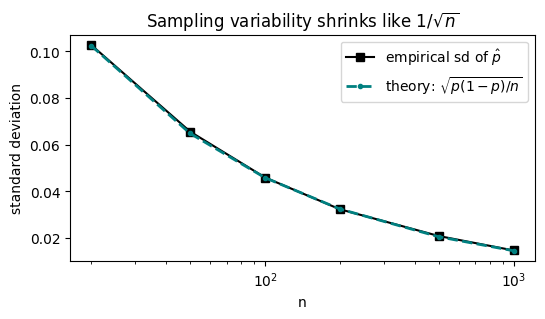

In [76]:
plt.figure(figsize=(6,3), dpi=100)

plt.plot(ns, sd_emp, marker='s', label='empirical sd of $\hat p$', color='k')
plt.plot(ns, sd_theory, marker='.', linestyle='--', lw=2,
         label='theory: $\sqrt{p(1-p)/n}$', color='teal')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('standard deviation')
plt.title('Sampling variability shrinks like $1/\sqrt{n}$')
plt.legend()

plt.show()

### 8.4 Standard errors in regression (high-level)

Under the Gaussian linear model:

$$
Y \mid X \sim \mathcal{N}(X\beta,\,\sigma^2 I),
$$

the OLS/MLE estimator has covariance:

$$
\operatorname{Var}(\hat\beta) = \sigma^2 (X^\top X)^{-1}.
$$

Software estimates $\sigma^2$ from residuals and reports standard errors from the diagonal.

In logistic regression, a similar idea holds, but with a different information matrix:

$$
\operatorname{Var}(\hat\beta) \approx \big(-\nabla^2 \ell(\hat\beta)\big)^{-1}.
$$

That’s why statsmodels can give you standard errors for logistic regression as well.


## See Appendix for Regressions from Scratch

## A toy xG model from shot locations

In soccer analytics, *expected goals* (xG) is a model-based estimate of the probability that a shot becomes a goal. If we denote the goal indicator for shot $i$ by $G_i \in \{0,1\}$, then an xG model is trying to estimate

$$
\mathrm{xG}_i \;=\; \mathbb{P}(G_i=1 \mid \text{context}_i).
$$

Once we have per-shot probabilities, match- or team-level xG is just an **expectation**:

$$
\mathbb{E}[\text{goals}] \;=\; \sum_i \mathrm{xG}_i.
$$

Here we build a deliberately simple baseline that uses only shot location $(X,Y)$ and the observed goal outcomes. This is not meant to be a production-quality model; the point is to connect xG to probability estimation (and, later, to likelihood-based modeling).


### Breakaway: “KDE xG” in one sentence

We place shots on a 2D grid, place goals on the same grid, smooth both with a Gaussian filter (a gridded KDE), and then take the ratio

$$
\widehat{\mathrm{xG}}(x,y) \;=\; \frac{\text{smooth}[\#\text{goals in bin}(x,y)]}{\text{smooth}[\#\text{shots in bin}(x,y)]}.
$$

Interpreting this: it is a **local average** of the goal indicator around $(x,y)$, so it is estimating $\mathbb{E}[G \mid X=x, Y=y]$ in a very direct (and very transparent) way.


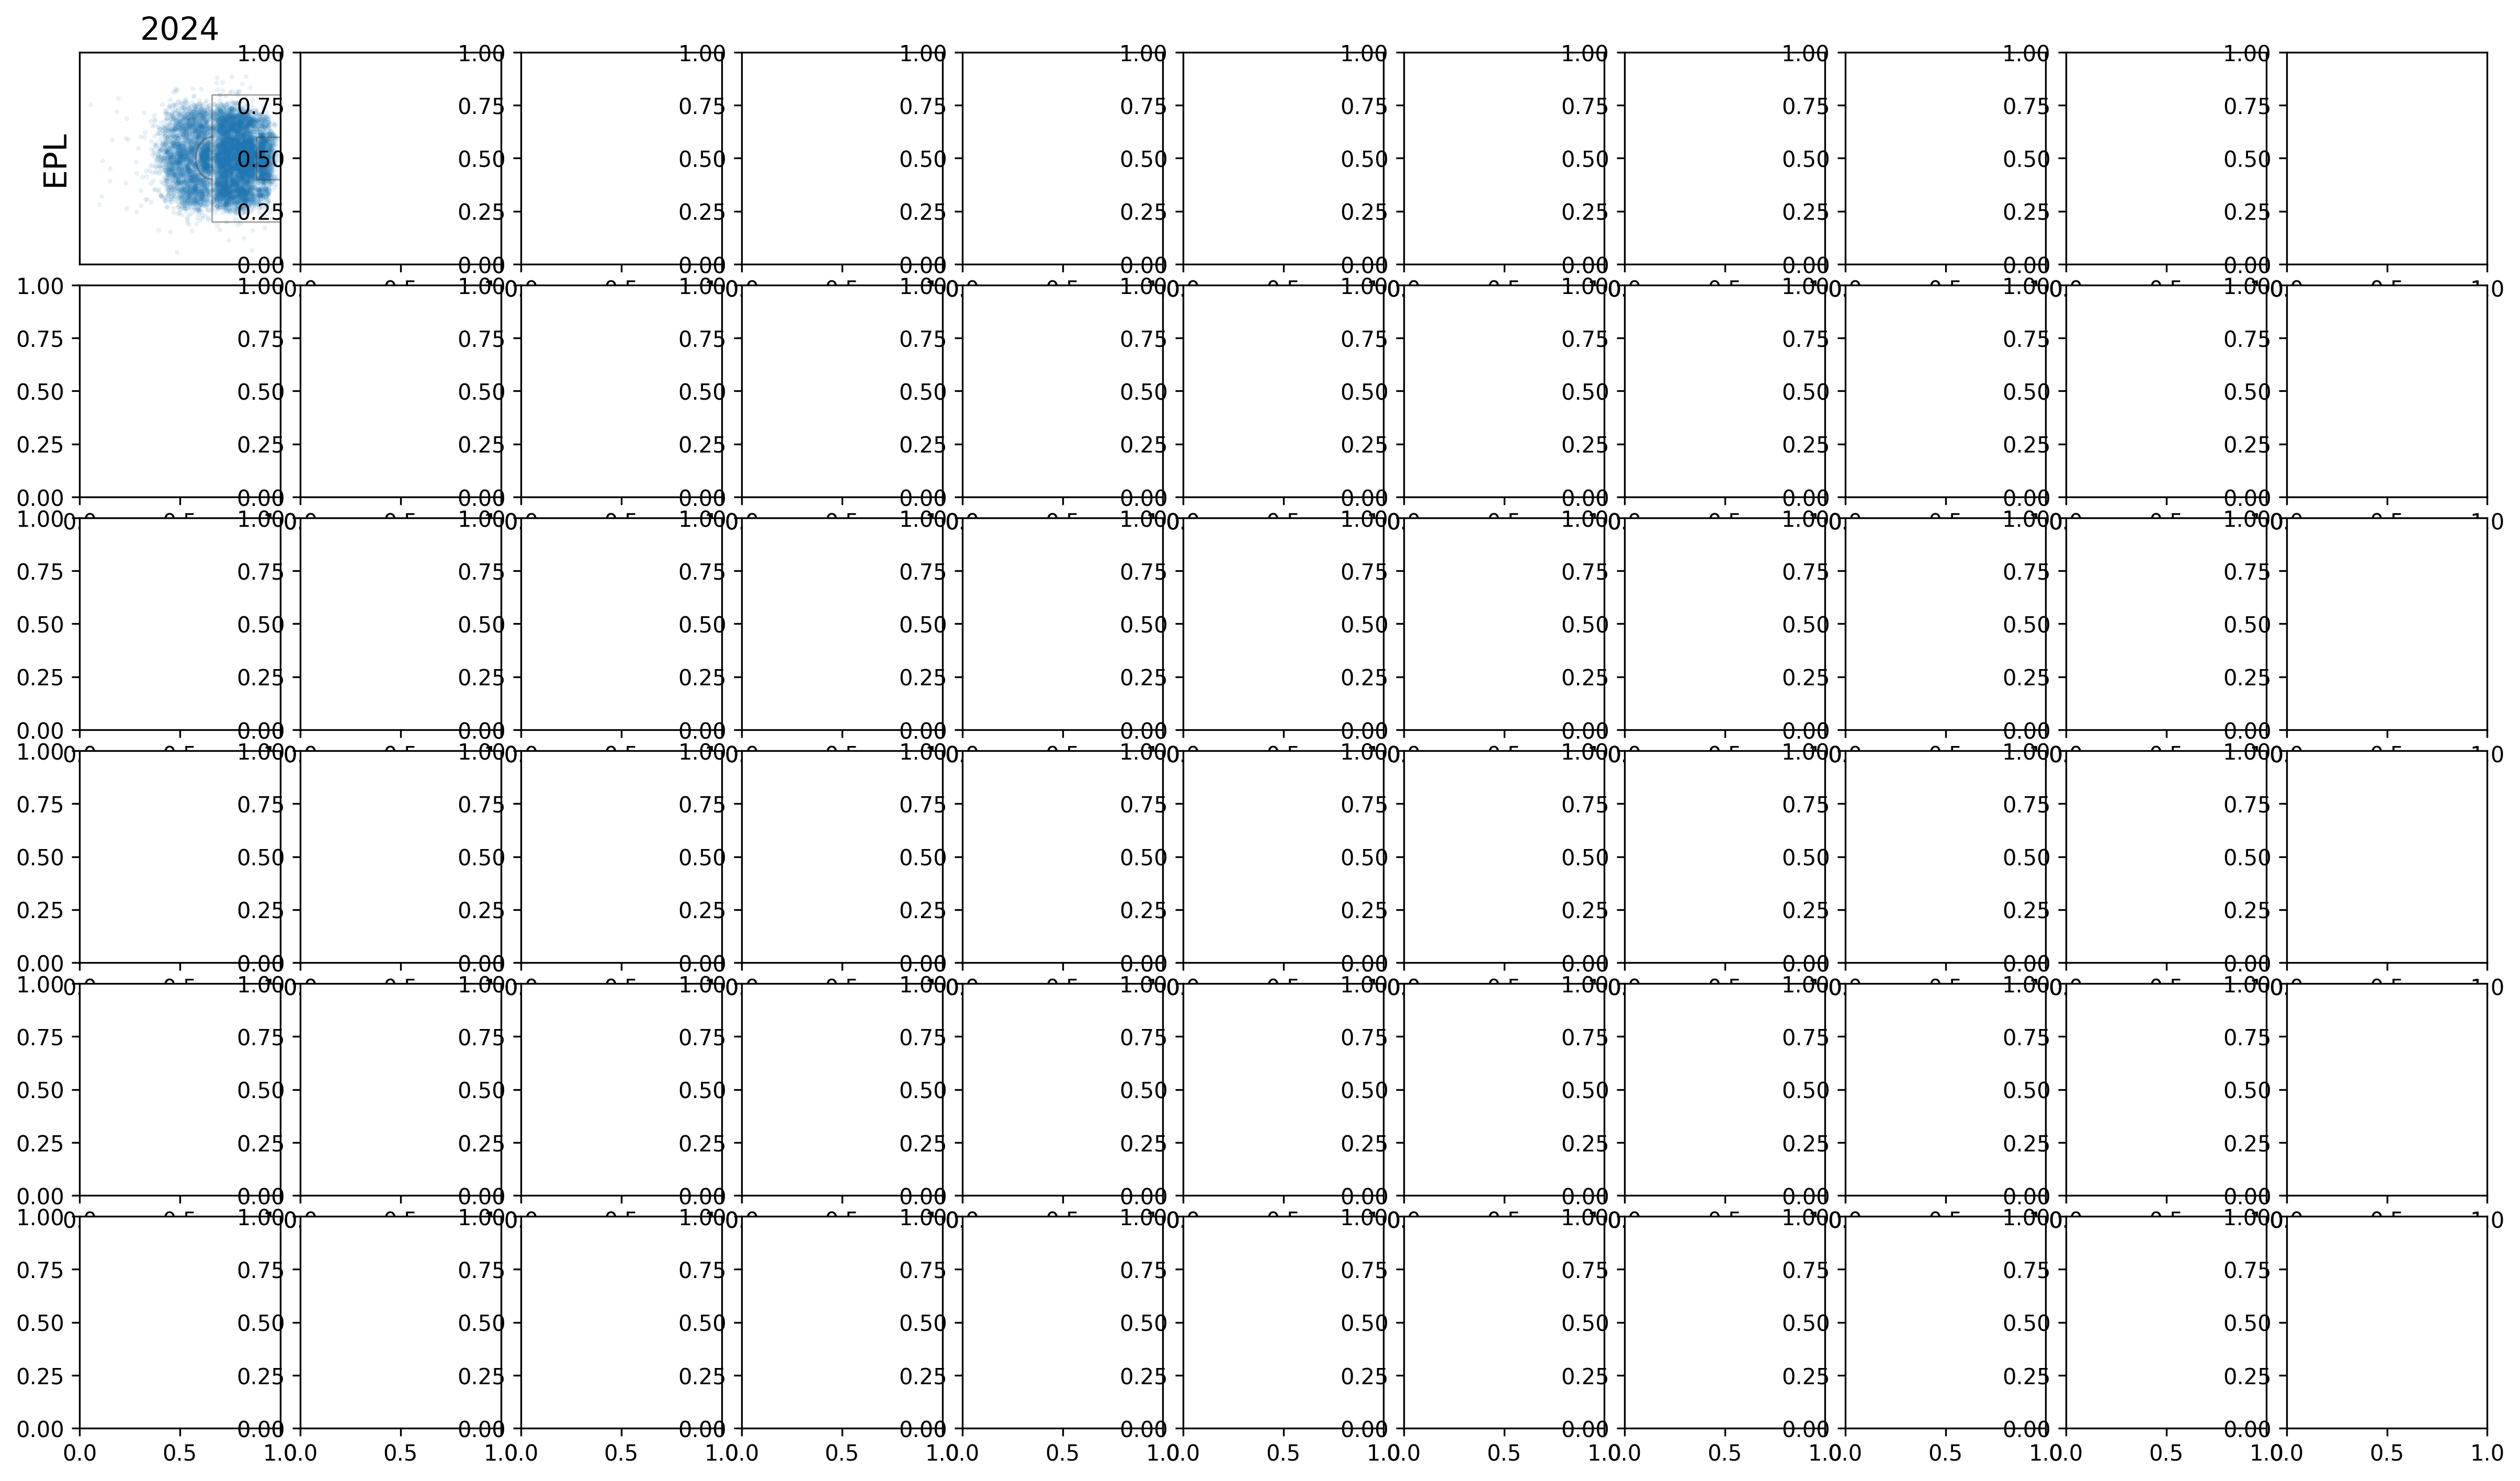

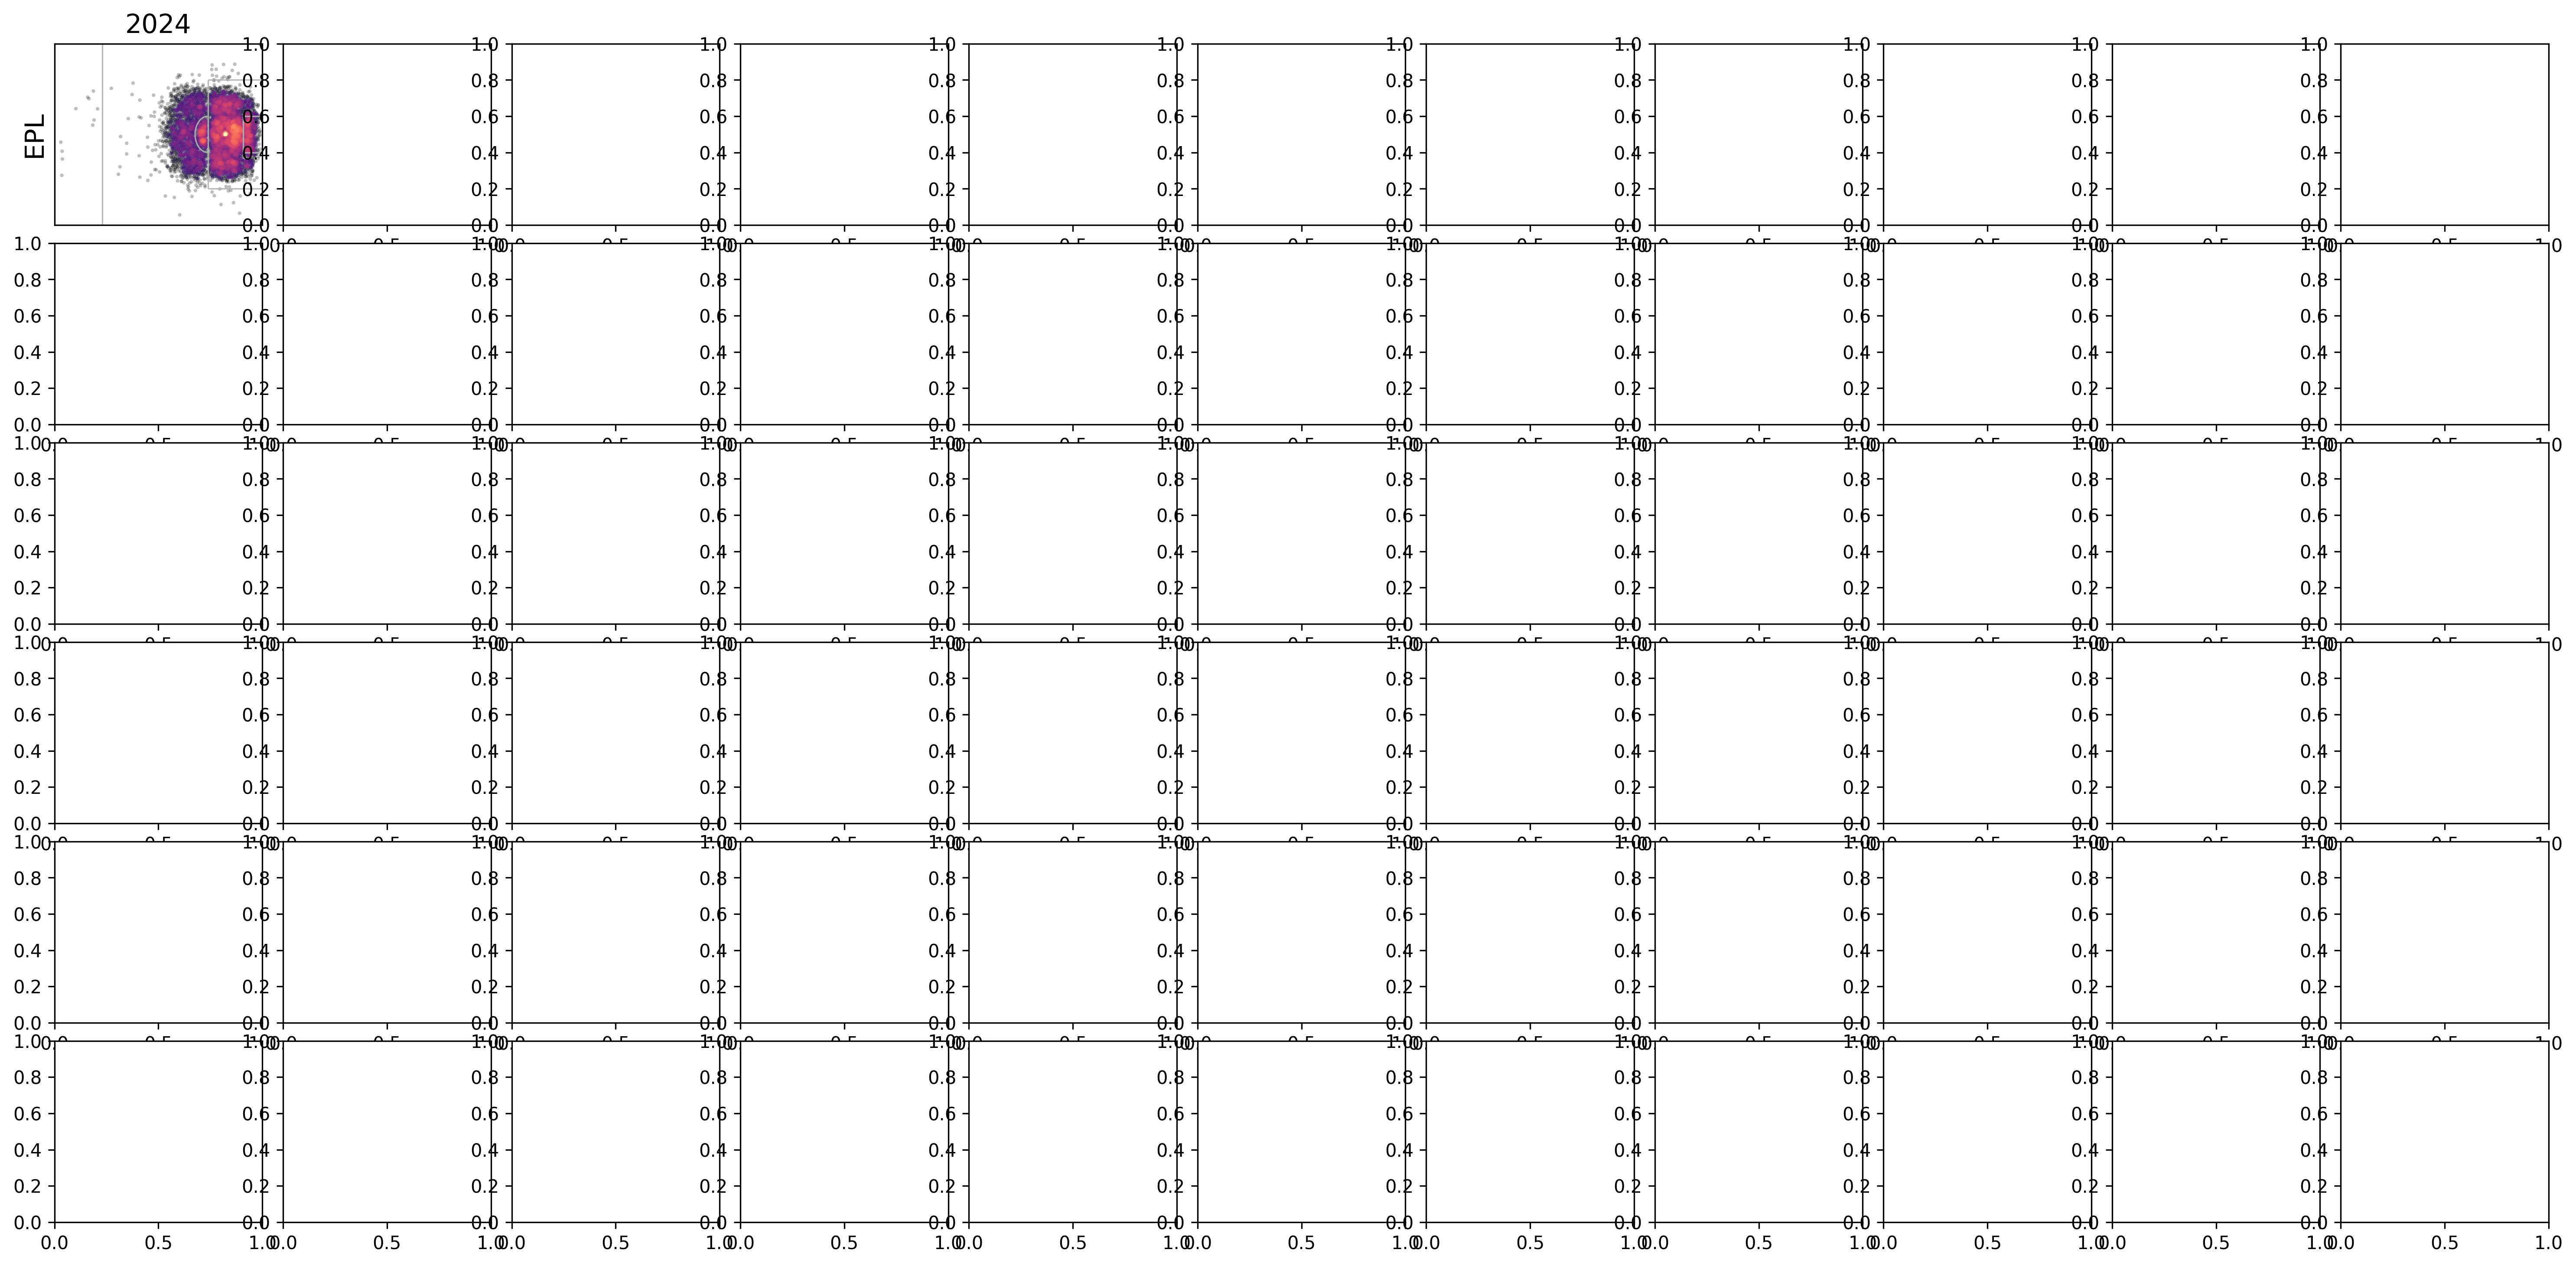

In [105]:
w = 2*0.9; h = 2.15*0.9
nrows = 6
ncols = 11

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=300)
plt.subplots_adjust(wspace=0.1,hspace=0.1)

for ix,league in enumerate(socc['league'].unique()):
    socc_l = socc.loc[socc['league']==league].copy()
    ax[(ix,0)].set_ylabel(league,fontsize='x-large')
    for iy,season in enumerate(socc_l['season'].unique()):
        socc_ls = socc_l.loc[socc_l['season']==season].copy()

        a = ax[(ix,iy)]
        a.scatter(socc_ls['X'].values,
                  socc_ls['Y'].values,marker='o',lw=0,
                  alpha=0.1,s=5)

        if ix==0:
            a.set_title(season,fontsize='x-large')

        arr = 0.1
        b = 0.04
        x0 = 0.50
        y0 = 0.4
        x = np.linspace(-arr + x0, arr + x0)
        y = b * np.sqrt(1 - ((x - x0) / arr) ** 2) + y0
        a.plot(-y+1.23, x,lw=0.8,color='.2',ls='-',alpha=0.4)
        a.vlines(0.83,0.8,0.2,lw=0.8,color='.2',ls='-',alpha=0.4)
        a.hlines(0.8,1.0,0.83,lw=0.8,color='.2',ls='-',alpha=0.4)
        a.hlines(0.2,1.0,0.83,lw=0.8,color='.2',ls='-',alpha=0.4)
        a.vlines(0.94,0.4,0.6,lw=0.8,color='.2',ls='-',alpha=0.4)
        a.hlines(0.4,1.0,0.94,lw=0.8,color='.2',ls='-',alpha=0.4)
        a.hlines(0.6,1.0,0.94,lw=0.8,color='.2',ls='-',alpha=0.4)


        a.set_ylim(0.0,1.00)
        a.set_xlim(0.5,1.00)
        a.set_xticks([])
        a.set_yticks([])


plt.show()


import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors

# --- per-panel KDE-like settings (NOT comparable across seasons/leagues) ---
xlim = (0.35, 1.0)
ylim = (0.0,  1.0)
bins = 200        # increase for finer detail
sigma = 1.1       # smoothing in "bin units"
eps = 1e-12

w = 2.25; h = 2.0
nrows = 6
ncols = 11

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w, nrows*h), dpi=300)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for ix, league in enumerate(socc['league'].unique()):
    socc_l = socc.loc[socc['league'] == league].copy()
    ax[(ix, 0)].set_ylabel(league.replace('_',' '), fontsize='x-large')

    for iy, season in enumerate(socc_l['season'].unique()):
        socc_ls = socc_l.loc[socc_l['season'] == season].copy()
        a = ax[(ix, iy)]

        xpts = socc_ls['X'].to_numpy()
        ypts = socc_ls['Y'].to_numpy()
        m = np.isfinite(xpts) & np.isfinite(ypts)
        xpts = xpts[m]
        ypts = ypts[m]

        if xpts.size == 0:
            # nothing to plot, but still format axes
            if ix == 0:
                a.set_title(season, fontsize='x-large')
            a.set_ylim(*ylim); a.set_xlim(*xlim)
            a.set_xticks([]); a.set_yticks([])
            continue

        # KDE-like density via smoothed 2D histogram (per-panel)
        H, xedges, yedges = np.histogram2d(xpts, ypts, bins=bins, range=[xlim, ylim])
        H = gaussian_filter(H, sigma=sigma)

        xi = np.clip(np.searchsorted(xedges, xpts, side="right") - 1, 0, H.shape[0] - 1)
        yi = np.clip(np.searchsorted(yedges, ypts, side="right") - 1, 0, H.shape[1] - 1)
        z = H[xi, yi] + eps

        # low-density first, high-density last
        order = np.argsort(z)
        z_ord = z[order]

        # per-panel normalization (NOT comparable across panels)
        vmin = np.percentile(z_ord, 5)
        vmax = np.percentile(z_ord, 99.7)
        norm = mcolors.LogNorm(vmin=max(vmin, eps), vmax=max(vmax, max(vmin, eps) * 1.01))

        a.scatter(
            xpts[order], ypts[order],
            c=z_ord,
            cmap="magma",
            norm=norm,
            marker="o",
            lw=0,
            s=4,
            alpha=0.25,
            rasterized=True
        )

        if ix == 0:
            a.set_title(season, fontsize='x-large')


        arr = 0.1
        b = 0.04
        x0 = 0.50
        y0 = 0.4
        x_arc = np.linspace(-arr + x0, arr + x0)
        y_arc = b * np.sqrt(1 - ((x_arc - x0) / arr) ** 2) + y0
        a.plot(-y_arc + 1.23, x_arc, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.vlines(0.83, 0.8, 0.2, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.hlines(0.8, 1.0, 0.83, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.hlines(0.2, 1.0, 0.83, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.vlines(0.94, 0.4, 0.6, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.hlines(0.4, 1.0, 0.94, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.hlines(0.6, 1.0, 0.94, lw=0.8, color='.7', ls='-', alpha=0.9)
        a.vlines(0.5, 0.0, 1.00, lw=0.8, color='.7', ls='-', alpha=0.9)

        a.set_ylim(*ylim)
        a.set_xlim(*xlim)
        a.set_xticks([])
        a.set_yticks([])


# plt.savefig('images/pngs/heatmap_soccer.png',dpi=600,bbox_inches='tight')
# plt.savefig('images/pdfs/heatmap_soccer.pdf',dpi=600,bbox_inches='tight')
plt.show()

socc['goal_yes'] = 0

socc.loc[socc['result']=='Goal','goal_yes'] = 1

socc[['X','Y','goal_yes']]

# socc[['league','season','match_id','shot_id','home_team','away_team','minute','X','Y','goal_yes']].to_csv('data/soccer/soccer_out.csv',index=False)

socc_df = socc[['league','season','match_id','shot_id','home_team','away_team','minute','X','Y','goal_yes']].copy()

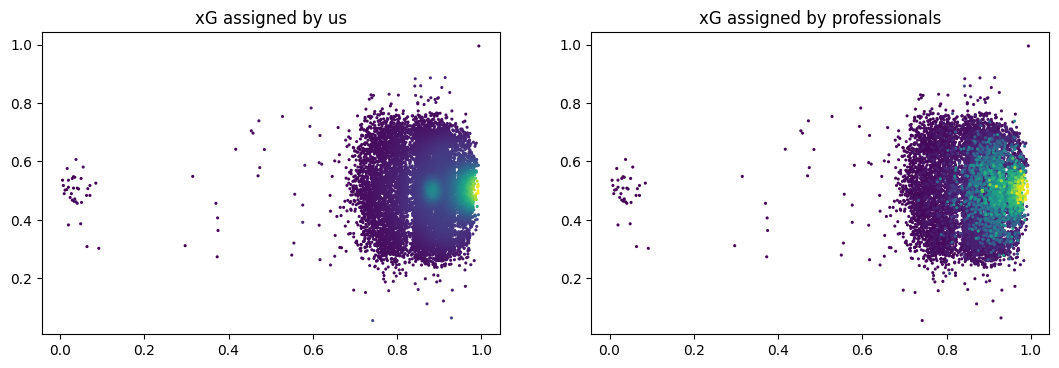

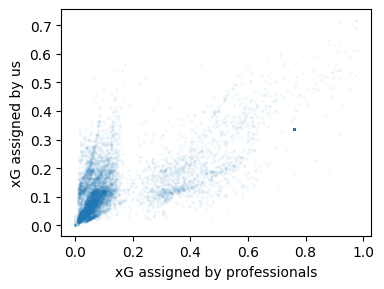

Observed goal rate:  0.10943510832152258
Mean predicted xG:   0.11653836592542405
Brier:   0.08801067934707624
LogLoss: 0.31067377750401576
AUC:     0.7312665037919223


In [106]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score

# ----------------------------
# Load your data
# ----------------------------
# path = "xG.csv"  # <- change if needed
# df = pd.read_csv(path)

# If you already have a DataFrame, just use it:
df = pd.read_csv("data/soccer/xG.csv")  # expects columns: X, Y, goal_yes


# ----------------------------
# Fit: nonparametric xG surface
# ----------------------------
def fit_xg_surface(
    data: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    goal_col: str = "goal_yes",
    xlim: tuple = (0.5, 1.0),
    ylim: tuple = (0.0, 1.0),
    bins: int = 120,
    sigma: float = 1.2,
    eps: float = 1e-6,
):
    """
    Very simple xG surface:
      xG(x,y) = smooth(goals(x,y)) / ( smooth(shots(x,y)) + eps )

    Returns:
      xg_grid: (bins x bins) array of xG values
      xedges, yedges: bin edges used for lookup
    """
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    g = data[goal_col].to_numpy().astype(int)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(g)
    x = x[m]; y = y[m]; g = g[m]

    # All shots
    shots, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[xlim, ylim])

    # Goals only (use same binning)
    goals, _, _ = np.histogram2d(x[g == 1], y[g == 1], bins=[xedges, yedges])

    # Smooth both
    shots_s = gaussian_filter(shots, sigma=sigma)
    goals_s = gaussian_filter(goals, sigma=sigma)

    # Ratio -> xG
    xg_grid = goals_s / (shots_s + eps)
    xg_grid = np.clip(xg_grid, 0.0, 1.0)

    return xg_grid, xedges, yedges


def assign_xg_from_surface(
    data: pd.DataFrame,
    xg_grid: np.ndarray,
    xedges: np.ndarray,
    yedges: np.ndarray,
    x_col: str = "X",
    y_col: str = "Y",
):
    """
    Assign each (X,Y) the xG value of its bin from xg_grid.
    """
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    m = np.isfinite(x) & np.isfinite(y)
    out = np.full(x.shape, np.nan, dtype=float)

    xi = np.searchsorted(xedges, x[m], side="right") - 1
    yi = np.searchsorted(yedges, y[m], side="right") - 1

    xi = np.clip(xi, 0, xg_grid.shape[0] - 1)
    yi = np.clip(yi, 0, xg_grid.shape[1] - 1)

    out[m] = xg_grid[xi, yi]
    return out

# Fit on all shots (global xG model)
xg_grid, xedges, yedges = fit_xg_surface(
    df,
    xlim=(0.5, 1.00),
    ylim=(0.0, 0.95),
    bins=200,
    sigma=5.0,
)


# Assign per-shot xG
df["xG"] = assign_xg_from_surface(df, xg_grid, xedges, yedges)
# df['xG'] = (df['xG']-df['xG'].min())/(df['xG'].max()-df['xG'].min())

socc['xG_0'] = socc['xG']
df = df.merge(socc[['shot_id','xG_0']])

fig, ax = plt.subplots(1,2,figsize=(13,4),dpi=100)

vals = ['xG','xG_0']
for i in range(2):
    val = vals[i]
    df_i = df.sort_values(val)
    ax[i].scatter(df_i['X'].values,df_i['Y'].values,
                  c=df_i[val].values,s=5,lw=0)

ax[0].set_title('xG assigned by us')
ax[1].set_title('xG assigned by professionals')

plt.show()

fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=100)
ax.scatter(df['xG_0'], df['xG'], alpha=0.05,lw=0,s=5)

ax.set_xlabel('xG assigned by professionals')
ax.set_ylabel('xG assigned by us')

plt.show()

# ----------------------------
# Tiny sanity checks
# ----------------------------
y_true = df["goal_yes"].to_numpy().astype(int)
y_pred = df["xG"].to_numpy()

print("Observed goal rate: ", y_true.mean())
print("Mean predicted xG:  ", np.nanmean(y_pred))

m = np.isfinite(y_pred)
print("Brier:  ", brier_score_loss(y_true[m], y_pred[m]))
print("LogLoss:", log_loss(y_true[m], y_pred[m], labels=[0, 1]))
print("AUC:    ", roc_auc_score(y_true[m], y_pred[m]))

__________
## Next time...
Regression Pt. 3 — Survival Analysis & Logistic Regression `class_07_regression_03_survival_logistic.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/jkbren/cnet5442_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5442-spring26
2. Hakes, J. K., & Sauer, R. D. (2006). *An economic evaluation of the Moneyball hypothesis.* Journal of Economic Perspectives, 20(3), 173–185.
3. Hastie, Tibshirani, Friedman. *The Elements of Statistical Learning* (classic reference for regression/GLMs).
4. Bishop. *Pattern Recognition and Machine Learning* (likelihood, logistic regression, Bayesian view).
5. Wikipedia overview + pointers (history, variants): https://en.wikipedia.org/wiki/Expected_goals
6. Mead et al. (2023). *Expected goals in football: Improving model performance and demonstrating value* (open access): https://pmc.ncbi.nlm.nih.gov/articles/PMC10075453/
7. These Football Times (2020). *The roots of Expected Goals (xG) and its journey from 'nerd nonsense' to the mainstream*: https://thesefootballtimes.co/2020/04/08/the-roots-of-expected-goals-xg-and-its-journey-from-nerd-nonsense-to-the-mainstream/
8. American Soccer Analysis (2015). *Do expected goals models lack style?* https://www.americansocceranalysis.com/home/2015/1/27/do-expected-goals-models-lack-style
9. Stats Perform (Opta) on xGOT (post-shot model): https://www.statsperform.com/resource/introducing-expected-goals-on-target-xgot/


_________



## Appendix - 4 - OLS in matrix form (and why it looks like a projection)

In Class 05, we mostly used software to fit linear regressions.

If you haven’t seen the matrix form before, it’s worth seeing the key equation once.

Let:

- $y$ be an $n\times 1$ vector of outcomes,
- $X$ be an $n\times p$ design matrix of features (including a column of ones for the intercept),
- $\beta$ be a $p\times 1$ vector of coefficients.

OLS chooses $\hat\beta$ to minimize the sum of squared residuals:

$$
\hat\beta = \operatorname*{argmin}_\beta \; \|y - X\beta\|_2^2.
$$

Differentiate w.r.t. $\beta$ and set to zero:

$$
\frac{\partial}{\partial \beta}\,\|y - X\beta\|_2^2
= -2X^\top(y - X\beta) = 0.
$$

This gives the **normal equations**:

$$
X^\top X\,\hat\beta = X^\top y.
$$

If $X^\top X$ is invertible:

$$
\hat\beta = (X^\top X)^{-1} X^\top y.
$$

Geometrically: $\hat y = X\hat\beta$ is the orthogonal projection of $y$ onto the column space of $X$.


In [77]:
# Verify the closed-form OLS solution matches sklearn
n = 200
X1 = np.random.normal(size=n)
X2 = np.random.normal(size=n)

# true model
beta0, beta1, beta2 = 1.5, -2.0, 0.7
y = beta0 + beta1*X1 + beta2*X2 + np.random.normal(0, 1.0, size=n)

# Build design matrix with intercept column
X = np.column_stack([np.ones(n), X1, X2])

# Closed-form OLS
beta_hat_closed = np.linalg.inv(X.T @ X) @ (X.T @ y)

# sklearn
lr = LinearRegression().fit(np.column_stack([X1, X2]), y)
beta_hat_sklearn = np.array([lr.intercept_, lr.coef_[0], lr.coef_[1]])

beta_hat_closed, beta_hat_sklearn


(array([ 1.46772567, -2.00410501,  0.7089926 ]),
 array([ 1.46772567, -2.00410501,  0.7089926 ]))

__________
## Appendix - 9 — Under the hood: logistic regression fitting from scratch
__________

If you want to see what’s happening under the hood, here’s the math and a clean implementation.


### 9.1 Rewrite the log-likelihood in a numerically stable form

Start from:

$$
\ell(\beta) = \sum_{i=1}^n \Big(y_i\log p_i + (1-y_i)\log(1-p_i)\Big)
$$

with $p_i = \sigma(\eta_i)$ and $\eta_i = x_i^\top\beta$.

A standard algebra trick yields:

$$
\ell(\beta) = \sum_{i=1}^n \Big(y_i\eta_i - \log(1+e^{\eta_i})\Big).
$$

This avoids computing $\log(1-p)$ directly.


### 9.2 Gradient and Hessian

Let $p$ be the vector of probabilities and let $W$ be a diagonal matrix with entries $p_i(1-p_i)$.

Then:

$$
\nabla\ell(\beta) = X^\top(y-p),
$$

and:

$$
\nabla^2\ell(\beta) = -X^\top W X.
$$


### 9.3 Newton's method / IRLS

To maximize $\ell(\beta)$, Newton updates are:

$$
\beta_{t+1} = \beta_t - \big(\nabla^2\ell(\beta_t)\big)^{-1}\,\nabla\ell(\beta_t).
$$

Because $\nabla^2\ell$ is negative definite, this moves uphill.


In [78]:
# Implement logistic regression via Newton's method (a.k.a. IRLS)

def loglik_logistic(beta, X, y):
    """Log-likelihood for a Bernoulli logistic regression model.

    Model:
        $$P(Y_i=1\mid x_i) = \sigma(x_i^\top\beta).$$

    This function returns:
        $$\ell(\beta) = \sum_i \big(y_i\eta_i - \log(1+e^{\eta_i})\big)$$
    with $\eta_i = x_i^\top\beta$.

    We compute $\log(1+e^{\eta})$ in a numerically stable way using `np.logaddexp`.
    """
    eta = X @ beta
    return np.sum(y*eta - np.logaddexp(0, eta))

def grad_logistic(beta, X, y):
    """Gradient of the logistic log-likelihood."""
    eta = X @ beta
    p = sigmoid(eta)
    return X.T @ (y - p)

def hess_logistic(beta, X, y):
    """Hessian of the logistic log-likelihood."""
    eta = X @ beta
    p = sigmoid(eta)
    w = p*(1-p)
    # Hessian of log-likelihood is -X^T W X (negative semidefinite)
    return -(X.T * w) @ X

def fit_logistic_newton(X, y, max_iter=50, tol=1e-8, ridge=1e-6):
    """Fit logistic regression by Newton's method.

    Parameters
    ----------
    X : array-like
        Design matrix (include intercept column if you want one).
    y : array-like
        Binary outcomes in {0, 1}.
    max_iter : int
        Maximum Newton iterations.
    tol : float
        Convergence tolerance on parameter change.
    ridge : float
        Tiny diagonal regularizer added to the Hessian if needed for numerical stability.

    Returns
    -------
    beta : np.ndarray
        Estimated coefficients.
    history : pandas.DataFrame
        Log-likelihood trajectory by iteration.
    """
    beta = np.zeros(X.shape[1])
    ll_prev = loglik_logistic(beta, X, y)
    history = [(0, ll_prev)]

    for t in range(1, max_iter + 1):
        g = grad_logistic(beta, X, y)
        H = hess_logistic(beta, X, y)

        # Numerical guard: if H is near-singular, add a tiny ridge term.
        # (This is rarely needed here, but it's good hygiene.)
        try:
            delta = np.linalg.solve(H, g)  # Newton step for maximizing
        except np.linalg.LinAlgError:
            H_ridge = H - ridge*np.eye(H.shape[0])
            delta = np.linalg.solve(H_ridge, g)

        beta_new = beta - delta
        ll_new = loglik_logistic(beta_new, X, y)
        history.append((t, ll_new))

        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break

        beta, ll_prev = beta_new, ll_new

    return beta, pd.DataFrame(history, columns=['iter', 'loglik'])

In [79]:
beta_newton, hist = fit_logistic_newton(X_sm, y_soc)
beta_newton, logit_model.params


(array([ 1.56688622,  1.67665958, -0.12787259]),
 array([ 1.56688622,  1.67665958, -0.12787259]))

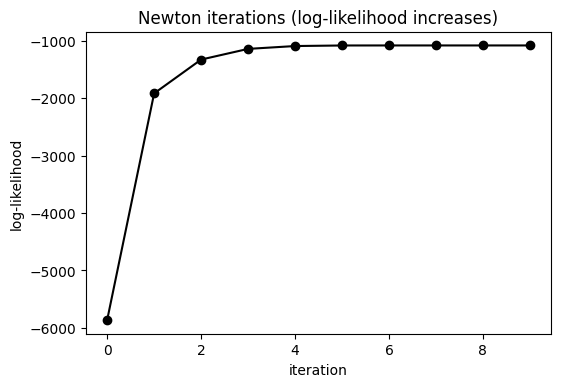

In [80]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(hist['iter'], hist['loglik'], marker='o', color='k')
plt.xlabel('iteration')
plt.ylabel('log-likelihood')
plt.title('Newton iterations (log-likelihood increases)')

plt.show()

In [81]:
grad_at_opt = grad_logistic(beta_newton, X_sm, y_soc)
np.max(np.abs(grad_at_opt))


1.98596694644948e-12

__________
## Appendix - Regularization, MAP, and why providers disagree even more


In practice, xG models often use regularization or more complex ML methods.

### 10.1 Penalized likelihood

A common approach is to maximize:

$$
\ell(\beta) - \lambda\,\Omega(\beta)
$$

where:

- $\ell(\beta)$ is log-likelihood,
- $\Omega(\beta)$ is a penalty,
- $\lambda$ controls strength.

Examples:

- Ridge: $\Omega(\beta)=\|\beta\|_2^2$
- Lasso: $\Omega(\beta)=\|\beta\|_1$

### 10.2 Bayesian view (MAP)

If you have a prior $p(\beta)$ and likelihood $p(y\mid X,\beta)$, Bayes says:

$$
p(\beta\mid X,y) \propto p(y\mid X,\beta)\,p(\beta).
$$

Taking logs:

$$
\log p(\beta\mid X,y) = \ell(\beta) + \log p(\beta) + \text{const}.
$$

Maximizing the posterior is MAP estimation. Many penalties correspond to specific priors.

This is one reason different teams/providers can legitimately get different xG values: modeling choices embed prior beliefs and practical constraints.
